Loan risk assessment is a critical task in the lending industry. It involves evaluating the likelihood of a borrower defaulting on a loan, and assigning a risk score based on their creditworthiness, financial history, and other relevant factors. The risk score helps lenders determine whether to approve the loan, and at what interest rate. However, accurately assessing loan risk is a complex and challenging task, requiring the analysis of large amounts of data, including credit reports, financial statements, and loan repayment histories. In this problem, we aim to use machine learning to build a loan risk model that can accurately predict the risk of default for new loan applications. By doing so, we can help lenders make more informed decisions about which loans to approve, and at what terms, ultimately reducing their overall risk exposure and improving their bottom line.

In this problem, we will be using 'loanStatus' from loan.csv as the target variable: <br>

The target variable is categorized into 2 classes:<br>
Class 'High' - meaning loans that are in high risk of defaulting<br>
Class 'Low' - meaning loans that are in low risk of defaulting<br>

Values in 'High': <br>

Internal Collection, External Collection, Returned Item, Charged Off Paid Off, Settled Bankruptcy, Settlement Paid Off, Charged Off and Settlement Pending Paid Off<br>

Values in 'Low': <br>

Paid Off Loan, New Loan and Pending Paid Off<br>

The advantage of binary class classification compared to multi-class classification in this case is predict_proba() can be used to visualized the probability of an application loan risk status to be either 'High' or 'Low', giving us the flexibility to manipulate and filter the applicants according the desired threshold<br>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Set the maximum number of rows and columns to be displayed to 500, maximum width of the console output to 1000 characters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
colors = ['#ffa600', '#bc5090', '#003f5c']
sns.set_palette(sns.color_palette(colors))
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(10, 10)})

In [4]:
# Read data from payment.csv, loan.csv, and clarity_underwriting_variables.csv and store them in payment, loan, and clarity dataframes
payment = pd.read_csv("payment.csv")
loan = pd.read_csv("loan.csv")
clarity = pd.read_csv("clarity_underwriting_variables.csv")

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\3767531977.py:4: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  clarity = pd.read_csv("clarity_underwriting_variables.csv")


# Data Understanding

#### Loan

In [5]:
# Convert to date format
loan['applicationDate'] = pd.to_datetime(loan['applicationDate'])
loan['applicationDate'] = loan['applicationDate'].dt.date
loan['originatedDate'] = pd.to_datetime(loan['originatedDate'])
loan['originatedDate'] = loan['originatedDate'].dt.date

In [6]:
# Check the min and max of applicationDate
loan['applicationDate'].min(), loan['applicationDate'].max()

(datetime.date(2014, 12, 3), datetime.date(2017, 3, 18))

In [7]:
# Function to calculate missing values with percentages by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                                    '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
               "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
# Missing values statistics
missing_values_loan = missing_values_table(loan)
missing_values_loan

The selected dataframe has 19 columns.
There are 10 columns that have missing values.


Missing Values  % of Total Values
originatedDate          531638               92.0
fpStatus                525959               91.0
clarityFraudId          219989               38.1
apr                       3922                0.7
loanAmount                2250                0.4
payFrequency              1273                0.2
loanStatus                 391                0.1
loanId                     256                0.0
state                      132                0.0
nPaidOff                    24                0.0

In [9]:
# Check the missing values in loanId
loan[loan['loanId'].isna()]

loanId                          anon_ssn payFrequency  apr applicationDate  originated originatedDate  nPaidOff  approved  isFunded loanStatus  loanAmount  originallyScheduledPaymentAmount state     leadType  leadCost     fpStatus            clarityFraudId  hasCF
1668      NaN  8f53d4e3d17fb490a16468f940992475            B  NaN      2015-06-23       False            NaT       0.0     False         0        NaN         NaN                               0.0    TX  bvMandatory         3  No Payments                       NaN      0
4749      NaN  ca89dd7de41d72d531311479cd9d166d            B  NaN      2016-01-07       False            NaT       0.0     False         0        NaN         NaN                               0.0    OH  bvMandatory         6  No Schedule                       NaN      0
5970      NaN  5d5adaa9cabb297235b0223c6e7182fc            B  NaN      2016-01-07       False            NaT       0.0     False         0        NaN         NaN                               0.0    IL  bvMandatory         3  No Schedule  568e01e0e4b040f8ae2d2694      1
16229     NaN  8e44524a86abe0db1f5c0f6afc9bbd7c            B  NaN      2016-06-15       False            NaT       0.0     False         0        NaN         NaN                               0.0    MI  bvMandatory         3  No Payments  5760c831e4b09f30d601f321      1
20193     NaN  213ad4d617b56bee5483f79837bcb6e6            B  NaN      2016-12-22       False            NaT       0.0     False         0        NaN         NaN                               0.0    AZ         lead        10  No Payments  585b79e7e4b08f24665c2b46      1
21191     NaN  6fb7174f109a89a35dab5d6e836b8bcb            W  NaN      2016-01-07       False            NaT       0.0     False         0        NaN         NaN                               0.0    MI  bvMandatory         3  No Schedule                       NaN      0
21389     NaN  4f67ecbc254571de0623b541f5212567            B  NaN      2015-11-03       False            NaT       0.0     False         0        NaN         NaN                               0.0    MI  bvMandatory         3  No Schedule                       NaN      0
22260     NaN  6547d474986024fb8b52f153b78f9ec4            M  NaN      2016-04-14       False            NaT       0.0     False         0        NaN         NaN                               0.0    TN  bvMandatory         3  No Schedule                       NaN      0
28672     NaN  ad9e3854914a6ff3db13a42da6d3ccf0            B  NaN      2015-12-10       False            NaT       0.0     False         0        NaN         NaN                               0.0    SC  bvMandatory         6  No Schedule                       NaN      0
30433     NaN  eb8dc1eafa970fb863a84903e84264ff            B  NaN      2016-01-07       False            NaT       0.0     False         0        NaN         NaN                               0.0    IL  bvMandatory         6  No Schedule                       NaN      0
30585     NaN  aef49a03e305286b3573ffbf57fc0ab1            W  NaN      2016-03-07       False            NaT       0.0     False         0        NaN         NaN                               0.0    MI  bvMandatory         6  No Schedule                       NaN      0
39343     NaN  53a6aeea59f67e613f63c27308e7b7b8            M  NaN      2015-05-05       False            NaT       0.0     False         0        NaN         NaN                               0.0    OH      organic         0  No Schedule                       NaN      0
40158     NaN  7f9dc87a062a320239bb2769a4ad6e83            B  NaN      2016-06-13       False            NaT       0.0     False         0        NaN         NaN                               0.0    TN  bvMandatory         6  No Payments                       NaN      0
41997     NaN  b47feaf9eb3fc282473304d5c556a9f0            B  NaN      2015-05-16       False            NaT       0.0     False         0        NaN         NaN                               0.0    OH      organi

##### Remove loan records with missing loanID, even if it contains valid anonymized social security numbers (SSN), as they do not provide valuable information and are suspected to be faulty.

In [10]:
# Remove missing values in loanID 
loan.dropna(subset=['loanId'], inplace=True)

In [11]:
# Change the name of column clarityFraudId to underwritingid
loan.rename(columns={"clarityFraudId": "underwritingid"}, inplace=True)

##### Do not drop duplicated values in anon_ssn as one person may have multiple loan applications

In [12]:
# Check duplicated potential duplicated values in columns "underwritingid", "anon_ssn" and "loanId"
row = ["underwritingid", "anon_ssn", "loanId"]
for i in row:
    num_duplicates = loan[i].duplicated().sum()
    print(f"Column '{i}' has {num_duplicates} duplicated values")

Column 'underwritingid' has 262561 duplicated values
Column 'anon_ssn' has 118160 duplicated values
Column 'loanId' has 0 duplicated values


#### Payment

In [13]:
# Convert to date format
payment['paymentDate'] = pd.to_datetime(payment['paymentDate'])
payment['paymentDate'] = payment['paymentDate'].dt.date

In [14]:
# Check the min and max of paymentDate
payment['paymentDate'].min(), payment['paymentDate'].max()

(datetime.date(2014, 12, 9), datetime.date(2021, 2, 26))

In [15]:
# Missing values statistics
missing_values_payment = missing_values_table(payment)
missing_values_payment

The selected dataframe has 9 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
paymentReturnCode          657831               95.4

In [16]:
# Count the number of occurrences of each unique value in the paymentReturnCode
payment['paymentReturnCode'].value_counts()

R01       22866
R02        2761
R08        2259
R16        1085
R10         620
MISSED      537
R03         318
RXS         226
R09         176
R07         160
C05         106
C01          87
R20          83
R99          60
RAF          58
R04          39
C03          34
C02          10
RWC           7
LPP01         7
R06           6
RUP           6
RBW           5
R29           4
RFG           3
R15           3
R13           2
C07           2
RIR           1
R19           1
RXL           1
Name: paymentReturnCode, dtype: int64

In [17]:
# Count the number of occurrences of each unique value in the paymentStatus
payment['paymentStatus'].value_counts()

Cancelled                  270334
Checked                    209621
None                       164057
Rejected                    32330
Pending                      9241
Skipped                      3761
Rejected Awaiting Retry        18
Returned                        1
Complete                        1
Name: paymentStatus, dtype: int64

In [18]:
payment['paymentStatus'] = payment['paymentStatus'].replace('Complete', 'Checked')

In [19]:
cat_columns = ['paymentStatus', 'paymentReturnCode']

In [20]:
# Encode paymentStatus and paymentReturnCode using one hot encoding
ohe = OneHotEncoder(handle_unknown = 'ignore')

# Fit OHE
ohe.fit(payment[cat_columns])
codes = ohe.transform(payment[cat_columns]).toarray()
feature_names = ohe.get_feature_names_out(cat_columns)
encoded_data = pd.DataFrame(codes,columns=feature_names).astype(int)

In [21]:
# concatenate encoded_data with payment
payment_encoded = pd.concat([payment,encoded_data],axis=1)
payment_encoded.shape

(689364, 49)

##### Evaluate applicants' based on paymentStatus and paymentReturnCode of each transactions done <br> For example, when paymentStatus is Checked means the payment is successful, the more the number of Checked status, meaning lower risk for the loan. Evidence to support this assumption can be found in Data Visualization part. 

In [22]:
# Group payment_encoded by loanId and aggregate payment information using sum for paymentStatus and paymentReturnCode 
agg_payment_encoded = payment_encoded.groupby('loanId').agg({
    'isCollection': lambda x: any(x),
    'paymentStatus_Cancelled': 'sum', 
    'paymentStatus_Checked': 'sum',
    'paymentStatus_None': 'sum', 
    'paymentStatus_Pending': 'sum',
    'paymentStatus_Rejected': 'sum', 
    'paymentStatus_Rejected Awaiting Retry': 'sum',
    'paymentStatus_Returned': 'sum', 
    'paymentStatus_Skipped': 'sum',
    'paymentReturnCode_C01': 'sum', 
    'paymentReturnCode_C02': 'sum',
    'paymentReturnCode_C03': 'sum', 
    'paymentReturnCode_C05': 'sum',
    'paymentReturnCode_C07': 'sum', 
    'paymentReturnCode_LPP01': 'sum',
    'paymentReturnCode_MISSED': 'sum', 
    'paymentReturnCode_R01': 'sum',
    'paymentReturnCode_R02': 'sum', 
    'paymentReturnCode_R03': 'sum',
    'paymentReturnCode_R04': 'sum', 
    'paymentReturnCode_R06': 'sum',
    'paymentReturnCode_R07': 'sum', 
    'paymentReturnCode_R08': 'sum',
    'paymentReturnCode_R09': 'sum', 
    'paymentReturnCode_R10': 'sum',
    'paymentReturnCode_R13': 'sum', 
    'paymentReturnCode_R15': 'sum',
    'paymentReturnCode_R16': 'sum', 
    'paymentReturnCode_R19': 'sum',
    'paymentReturnCode_R20': 'sum', 
    'paymentReturnCode_R29': 'sum',
    'paymentReturnCode_R99': 'sum', 
    'paymentReturnCode_RAF': 'sum',
    'paymentReturnCode_RBW': 'sum', 
    'paymentReturnCode_RFG': 'sum',
    'paymentReturnCode_RIR': 'sum', 
    'paymentReturnCode_RUP': 'sum',
    'paymentReturnCode_RWC': 'sum', 
    'paymentReturnCode_RXL': 'sum',
    'paymentReturnCode_RXS': 'sum', 
    'paymentReturnCode_nan': 'sum'
})

In [23]:
agg_payment_encoded = agg_payment_encoded.reset_index().rename(columns={'index': 'loanId'})
agg_payment_encoded

loanId  isCollection  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentStatus_Rejected Awaiting Retry  paymentStatus_Returned  paymentStatus_Skipped  paymentReturnCode_C01  paymentReturnCode_C02  paymentReturnCode_C03  paymentReturnCode_C05  paymentReturnCode_C07  paymentReturnCode_LPP01  paymentReturnCode_MISSED  paymentReturnCode_R01  paymentReturnCode_R02  paymentReturnCode_R03  paymentReturnCode_R04  paymentReturnCode_R06  paymentReturnCode_R07  paymentReturnCode_R08  paymentReturnCode_R09  paymentReturnCode_R10  paymentReturnCode_R13  paymentReturnCode_R15  paymentReturnCode_R16  paymentReturnCode_R19  paymentReturnCode_R20  paymentReturnCode_R29  paymentReturnCode_R99  paymentReturnCode_RAF  paymentReturnCode_RBW  paymentReturnCode_RFG  paymentReturnCode_RIR  paymentReturnCode_RUP  paymentReturnCode_RWC  paymentReturnCode_RXL  paymentReturnCode_RXS  paymentReturnCode_nan
0      LL-I-00000021          True                        0                     12                   0                      0                       1                                      0                       0                      0                      0                      0                      0                      0                      0                        0                         0                      1                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                     12
1      LL-I-00000231         False                        8                      2                   8                      0                       2                                      0                       0                      0                      0                      0                      0                      0                      0                        0                         0                      2                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                     18
2      LL-I-00000238         False                        4                      7                   4                      0                       1                                      0                       0                      0                      0                      0                      0                      0                      0                        0                         0                      0                      0                      0                      0                      0                      0                      1                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                      0                     15
3      LL-I-00000308         False                       10                      1                  10    

#### Clarity

In [24]:
# Missing values statistics
missing_values_clarity = missing_values_table(clarity)
missing_values_clarity

The selected dataframe has 54 columns.
There are 53 columns that have missing values.


Missing Values  % of Total Values
.underwritingdataclarity.clearfraud.clearfraudi...           48237               97.0
.underwritingdataclarity.clearfraud.clearfraudi...           47083               94.6
.underwritingdataclarity.clearfraud.clearfraudi...           47083               94.6
.underwritingdataclarity.clearfraud.clearfraudi...           44125               88.7
.underwritingdataclarity.clearfraud.clearfraudi...           44125               88.7
.underwritingdataclarity.clearfraud.clearfraudi...           40723               81.9
.underwritingdataclarity.clearfraud.clearfraudi...           39697               79.8
.underwritingdataclarity.clearfraud.clearfraudi...           28336               57.0
.underwritingdataclarity.clearfraud.clearfraudi...           28336               57.0
.underwritingdataclarity.clearfraud.clearfraudi...            5049               10.1
.underwritingdataclarity.clearfraud.clearfraudi...             953                1.9
.underwritingdataclarity.clearfraud.clearfraudi...             953                1.9
.underwritingdataclarity.clearfraud.clearfraudi...             681                1.4
clearfraudscore                                                137                0.3
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              40                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              32                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              32                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              32                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              32                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              32                0.1
.underwritingdataclarity.clearfraud.clearfraudi...              17                0.0
.underwritingdataclarity.clearfraud.clearfraudi...              17                0.0
.underwritingdataclarity.clearfraud.clearfraudi...               2                0.0
.underwritingdataclarity.clearfraud.clearfraudi...               2                0.0
.underwrit

In [25]:
sns.set(rc={'figure.figsize':(10, 10)})

<AxesSubplot:xlabel='clearfraudscore', ylabel='Count'>

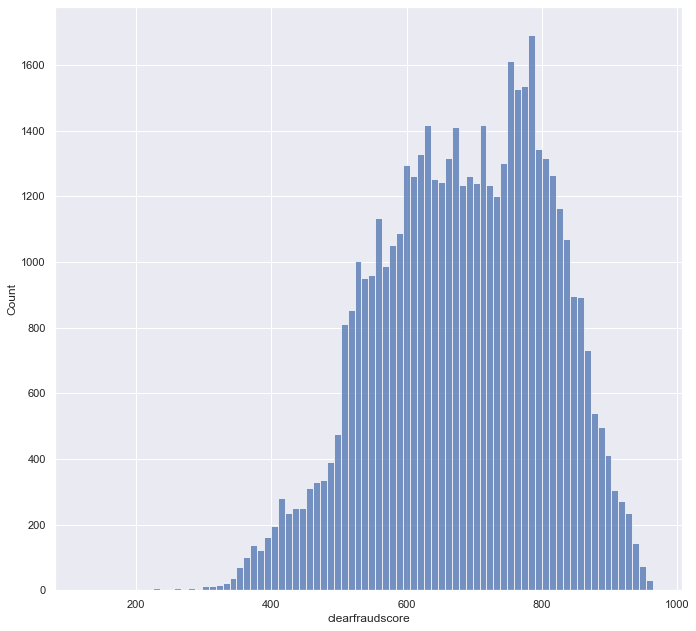

In [26]:
# A high clear fraud score indicates that a loan is less likely to be fraudulent
sns.histplot(data=clarity, x="clearfraudscore")

In [27]:
# object_columns = clarity.select_dtypes(include='object')
# float_columns = clarity.select_dtypes(include='float64')
# object_columns['clearfraudscore'] = float_columns['clearfraudscore'].copy()

In [28]:
# # Plot the distribution of each values in object datatype columns against clearfraudscore
# for i in object_columns.drop(['clearfraudscore', 'underwritingid'], axis=1).keys():
#     sns.histplot(data=clarity, x="clearfraudscore", hue=i, stat='density', common_norm=False)
#     plt.show()

In [29]:
# # Plot the distribution of each numeric datatype columns against clearfraudscore
# for i in float_columns.keys():
#     sns.scatterplot(data=float_columns, x="clearfraudscore", y=i)
#     plt.title(i)
#     plt.show()

In [30]:
# Select only underwritingid and clearfraudscore
clarity_clearfraudscore = clarity[['underwritingid', 'clearfraudscore']]

#### Loan x Payment x Clarity

In [31]:
# Merge loan, payment and clarity tables together
df = pd.merge(loan, agg_payment_encoded, on='loanId', how='left')
df = pd.merge(df, clarity_clearfraudscore, on='underwritingid', how='left')
df

loanId                          anon_ssn payFrequency    apr applicationDate  originated originatedDate  nPaidOff  approved  isFunded             loanStatus  loanAmount  originallyScheduledPaymentAmount state     leadType  leadCost fpStatus            underwritingid  hasCF isCollection  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentStatus_Rejected Awaiting Retry  paymentStatus_Returned  paymentStatus_Skipped  paymentReturnCode_C01  paymentReturnCode_C02  paymentReturnCode_C03  paymentReturnCode_C05  paymentReturnCode_C07  paymentReturnCode_LPP01  paymentReturnCode_MISSED  paymentReturnCode_R01  paymentReturnCode_R02  paymentReturnCode_R03  paymentReturnCode_R04  paymentReturnCode_R06  paymentReturnCode_R07  paymentReturnCode_R08  paymentReturnCode_R09  paymentReturnCode_R10  paymentReturnCode_R13  paymentReturnCode_R15  paymentReturnCode_R16  paymentReturnCode_R19  paymentReturnCode_R20  \
0       LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0      2016-02-23       False            NaT       0.0     False         0  Withdrawn Application       500.0                            978.27    IL  bvMandatory         6      NaN  5669ef78e4b0c9d3936440e6      1          NaN                      NaN                    NaN                 NaN                    NaN                     NaN                                    NaN                     NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                      NaN                       NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN   
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0      2016-01-19        True     2016-01-20       0.0      True         1          Paid Off Loan      3000.0                           6395.19    CA    prescreen         0  Checked  569eb3a3e4b096699f685d64      1        False                      3.0                   22.0                 0.0                    0.0                     0.0                                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                      0.0                       0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0   
2       LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0      2016-08-01       False            NaT       0.0     False         0  Withdrawn Application       400.0                           1199.45    MO  bvMandatory         3      NaN  579eab11e4b0d0502870ef2f      1          NaN                      NaN                    NaN                 NaN                    NaN                     NaN                                    NaN                     NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                      NaN                       NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN   
3       LL-I-02272596  9be6f443bb97db7e

# Data Preparation

##### Only funded loans are considered, where idFunded = 1

In [32]:
df = df[df['isFunded'] == 1]

In [33]:
# Missing values statistics
missing_values_df = missing_values_table(df)
missing_values_df

The selected dataframe has 61 columns.
There are 45 columns that have missing values.


Missing Values  % of Total Values
clearfraudscore                                  6894               17.7
underwritingid                                   6622               17.0
paymentReturnCode_R99                             104                0.3
paymentReturnCode_R08                             104                0.3
paymentReturnCode_R09                             104                0.3
paymentReturnCode_R10                             104                0.3
paymentReturnCode_R13                             104                0.3
paymentReturnCode_R15                             104                0.3
paymentReturnCode_R16                             104                0.3
paymentReturnCode_R19                             104                0.3
paymentReturnCode_R20                             104                0.3
paymentReturnCode_R29                             104                0.3
paymentReturnCode_RAF                             104                0.3
paymentReturnCode_R06                             104                0.3
paymentReturnCode_RBW                             104                0.3
paymentReturnCode_RFG                             104                0.3
paymentReturnCode_RIR                             104                0.3
paymentReturnCode_RUP                             104                0.3
paymentReturnCode_RWC                             104                0.3
paymentReturnCode_RXL                             104                0.3
paymentReturnCode_RXS                             104                0.3
paymentReturnCode_nan                             104                0.3
paymentReturnCode_R07                             104                0.3
paymentReturnCode_R04                             104                0.3
paymentReturnCode_C01                             104                0.3
paymentReturnCode_R03                             104                0.3
paymentStatus_Checked                             104                0.3
paymentStatus_None                                104                0.3
paymentStatus_Pending                             104                0.3
paymentStatus_Rejected                            104                0.3
paymentStatus_Rejected Awaiting Retry             104                0.3
paymentStatus_Returned                            104                0.3
paymentStatus_Skipped                             104                0.3
paymentReturnCode_C02                             104                0.3
isCollection                                      104                0.3
paymentReturnCode_C03                             104                0.3
paymentReturnCode_C05                             104                0.3
paymentReturnCode_C07                             104                0.3
paymentReturnCode_LPP01                           104                0.3
paymentReturnCode_MISSED                          104                0.3
paymentReturnCode_R01                             104                0.3
paymentReturnCode_R02                             104                0.3
paymentStatus_Cancelled                           104                0.3
nPaidOff                                           21                0.1
fpStatus                                            9                0.0

##### fpStatus <br>
9 missing values. 8 of them are because 'None' from paymentStatus column in payment table is recognised as NaN, remaining 1 is because it is not found in payment table<br>

Steps:<br>
1. fill the 8 NaN with None<br>
2. and remove the last nan (suspicous, no payment until 2021)<br>

In [34]:
df[df['fpStatus'].isna() == True]['loanId'].unique()

array(['LL-I-03851940', 'LL-I-04040626', 'LL-T-00317558', 'LL-I-00984037',
       'LL-I-04464756', 'LL-I-18496618', 'LL-T-01984747', 'LL-I-03443286',
       'LL-I-02769536'], dtype=object)

In [35]:
# filter the dataframe to rows where the loanID is the 9 missing fpStatus corresponding loanID
mask = payment['loanId'].isin(['LL-I-03851940', 'LL-I-04040626', 'LL-T-00317558', 'LL-I-00984037','LL-I-04464756', 
                               'LL-I-18496618', 'LL-T-01984747', 'LL-I-03443286','LL-I-02769536'])

fpStatus_nan = payment[mask]

# group by loanID and select the first row for each group
fpStatus_nan = fpStatus_nan.groupby('loanId').first()
fpStatus_nan = fpStatus_nan.reset_index().rename(columns={'index': 'loanId'})
fpStatus_nan[['loanId', 'paymentStatus']]

loanId paymentStatus
0  LL-I-00984037          None
1  LL-I-02769536          None
2  LL-I-03443286          None
3  LL-I-03851940          None
4  LL-I-04040626          None
5  LL-I-04464756          None
6  LL-T-00317558          None
7  LL-T-01984747          None

In [36]:
# Replace NaN with 'None'
df.loc[df['loanId'].isin(['LL-I-03851940', 'LL-I-04040626', 'LL-T-00317558', 'LL-I-00984037','LL-I-04464756', 
                          'LL-T-01984747', 'LL-I-03443286','LL-I-02769536']), 'fpStatus'] = 'None'

In [37]:
# Remove the one missing value because it is not found in payment table
df.drop(df[df['loanId'] == 'LL-I-18496618'].index, inplace=True)

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\289946171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['loanId'] == 'LL-I-18496618'].index, inplace=True)


In [38]:
# Remove this because it seems suspicious, no payment since 2017
df.drop(df[df['fpStatus'] == 'Returned'].index, inplace=True)

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\2520919348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['fpStatus'] == 'Returned'].index, inplace=True)


##### nPaidOff <br>
21 missing values, filled with median

In [39]:
df['nPaidOff'] = df['nPaidOff'].fillna(df['nPaidOff'].median())

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\1410921526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nPaidOff'] = df['nPaidOff'].fillna(df['nPaidOff'].median())


##### isCollection <br> 
104 missing values<br>
Same problem with paymentReturnCode and paymentStatus<br>
remove all of them

In [40]:
df[df['isCollection'].isna() == True].describe()

apr    nPaidOff  isFunded   loanAmount  originallyScheduledPaymentAmount    leadCost       hasCF  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentStatus_Rejected Awaiting Retry  paymentStatus_Returned  paymentStatus_Skipped  paymentReturnCode_C01  paymentReturnCode_C02  paymentReturnCode_C03  paymentReturnCode_C05  paymentReturnCode_C07  paymentReturnCode_LPP01  paymentReturnCode_MISSED  paymentReturnCode_R01  paymentReturnCode_R02  paymentReturnCode_R03  paymentReturnCode_R04  paymentReturnCode_R06  paymentReturnCode_R07  paymentReturnCode_R08  paymentReturnCode_R09  paymentReturnCode_R10  paymentReturnCode_R13  paymentReturnCode_R15  paymentReturnCode_R16  paymentReturnCode_R19  paymentReturnCode_R20  paymentReturnCode_R29  paymentReturnCode_R99  paymentReturnCode_RAF  paymentReturnCode_RBW  paymentReturnCode_RFG  paymentReturnCode_RIR  paymentReturnCode_RUP  paymentReturnCode_RWC  \
count  103.000000  103.000000     103.0   103.000000                        103.000000  103.000000  103.000000                      0.0                    0.0                 0.0                    0.0                     0.0                                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                      0.0                       0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0   
mean   421.917767    0.368932       1.0  1385.941748                       4342.308641   22.048544    0.990291                      NaN                    NaN                 NaN                    NaN                     NaN                                    NaN                     NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                      NaN                       NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN   
std    204.061513    1.009662       0.0  1108.761655                       3713.238049   17.088225    0.098533                      NaN                    NaN                 NaN                    NaN                     NaN                                    NaN                     NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                      NaN                       NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN                    NaN   
min    159.000000    0.000000       1.0   300.000000              

In [41]:
df[df['isCollection'].isna() == True]['loanId'].isin(payment['loanId']).sum()

0

In [42]:
df[df['isCollection'].isna() == True]['loanId'].to_numpy()

array(['LL-I-18537570', 'LL-I-18574284', 'LL-I-18619260', 'LL-I-18516060',
       'LL-I-18545351', 'LL-I-18584520', 'LL-I-18571864', 'LL-I-18589170',
       'LL-I-18547233', 'LL-I-18401799', 'LL-I-18538278', 'LL-I-18611067',
       'LL-I-18614963', 'LL-I-18571077', 'LL-I-18628365', 'LL-I-18615217',
       'LL-I-18568539', 'LL-I-18597698', 'LL-I-18590610', 'LL-I-18297431',
       'LL-I-18608691', 'LL-I-18292147', 'LL-I-18612943', 'LL-I-18354064',
       'LL-I-18456533', 'LL-I-18194894', 'LL-I-18614455', 'LL-I-18628898',
       'LL-I-18592979', 'LL-I-18336015', 'LL-I-18245979', 'LL-I-18358520',
       'LL-I-18611923', 'LL-I-18306121', 'LL-I-18479296', 'LL-I-18596423',
       'LL-I-18595098', 'LL-I-18552825', 'LL-I-18503858', 'LL-I-18420293',
       'LL-I-18604206', 'LL-I-18619359', 'LL-I-18620395', 'LL-I-18540045',
       'LL-I-18419282', 'LL-I-18440054', 'LL-I-18375768', 'LL-I-18537496',
       'LL-I-18628037', 'LL-I-18579971', 'LL-I-18500965', 'LL-I-18545891',
       'LL-I-18297746', '

In [43]:
# Remove isCollection, paymentReturnCode and paymentStatus with missing values
for i in df[df['isCollection'].isna() == True]['loanId'].to_numpy(): 
    df.drop(df[df['loanId'] == i].index, inplace=True)

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\260298875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[df['loanId'] == i].index, inplace=True)


In [44]:
# Convert into int datatype
encode = {True : 1, False : 0}

df['isCollection'] = df['isCollection'].map(encode)
df['originated'] = df['originated'].map(encode)
df['approved'] = df['approved'].map(encode)

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\2932112451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isCollection'] = df['isCollection'].map(encode)
C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\2932112451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['originated'] = df['originated'].map(encode)
C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\2932112451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

##### Check numeric outliers

In [45]:
sns.set(rc={'figure.figsize':(10, 10)})

apr                                     AxesSubplot(0.08,0.641765;0.395455x0.238235)
nPaidOff                            AxesSubplot(0.554545,0.641765;0.395455x0.238235)
loanAmount                              AxesSubplot(0.08,0.355882;0.395455x0.238235)
originallyScheduledPaymentAmount    AxesSubplot(0.554545,0.355882;0.395455x0.238235)
leadCost                                    AxesSubplot(0.08,0.07;0.395455x0.238235)
clearfraudscore                         AxesSubplot(0.554545,0.07;0.395455x0.238235)
dtype: object

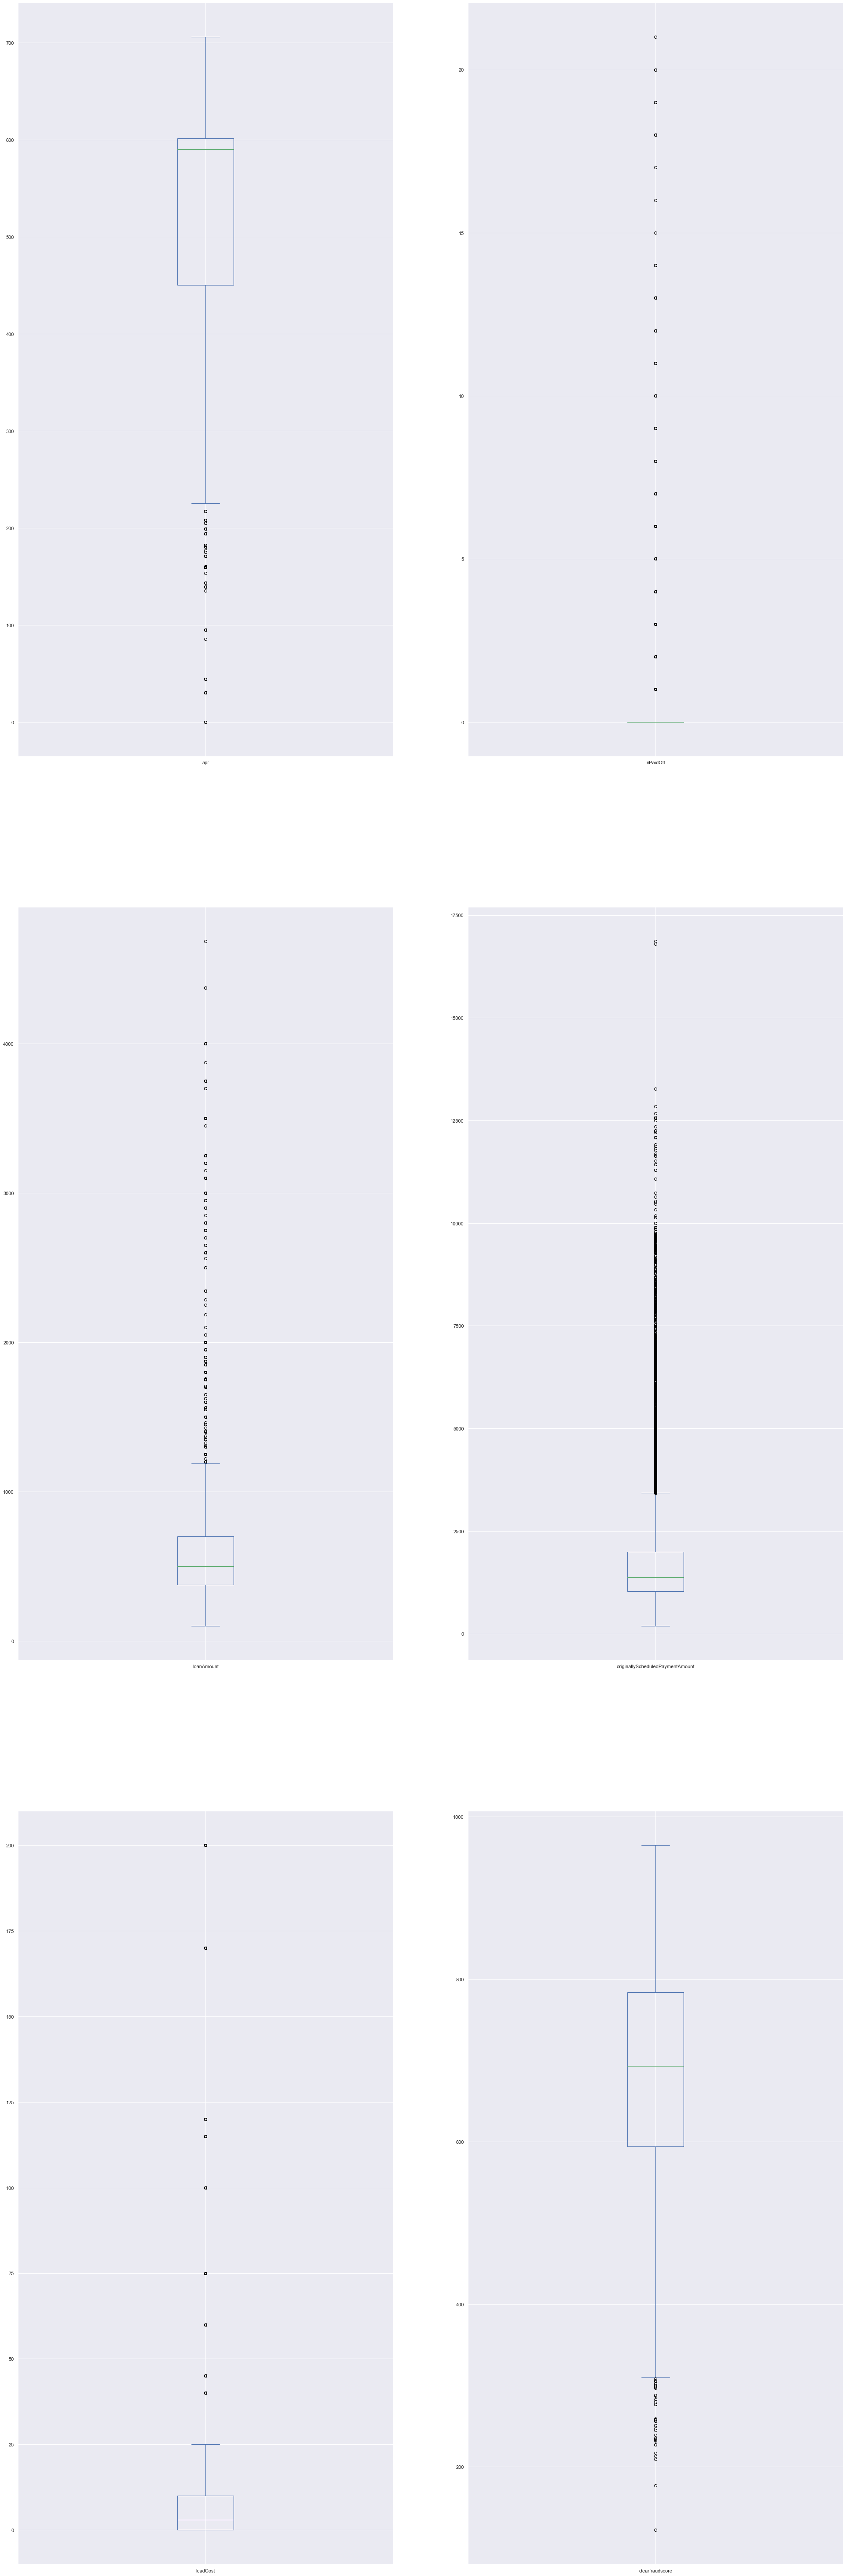

In [46]:
#plot boxlot for each numerical column
df[['apr', 'nPaidOff', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost', 
    'clearfraudscore']].plot(kind="box",subplots=True, layout=(3,2), figsize=(30,100))

##### Check categorical formatting error

In [47]:
# Observe the values in columns to see if there is any formatting error or spelling error
column_categorical = ['payFrequency','loanStatus','state','leadType','fpStatus']

length_col=len(column_categorical)
def col_values(table):
    m = 0
    while m < length_col:
        columns_values = table[column_categorical[m]].unique()
        print(column_categorical[m],": ",columns_values,"\n")
        m = m + 1
        
col_values(df)

payFrequency :  ['B' 'W' 'S' 'M' 'I'] 

loanStatus :  ['Paid Off Loan' 'New Loan' 'Internal Collection' 'External Collection'
 'Returned Item' 'Pending Paid Off' 'Charged Off Paid Off'
 'Settled Bankruptcy' 'Settlement Paid Off' 'Charged Off'
 'Settlement Pending Paid Off'] 

state :  ['CA' 'MO' 'NJ' 'WI' 'IL' 'MI' 'FL' 'SC' 'OH' 'NV' 'IN' 'VA' 'TN' 'OK'
 'NC' 'TX' 'PA' 'HI' 'MS' 'KY' 'AL' 'GA' 'NM' 'ID' 'ND' 'AZ' 'CO' 'NE'
 'SD' 'MN' 'LA' 'CT' 'WY' 'KS' 'DE' 'WA' 'UT' 'RI' 'IA' 'AK' 'MD'] 

leadType :  ['prescreen' 'organic' 'lead' 'bvMandatory' 'rc_returning' 'california'
 'instant-offer' 'express' 'repeat' 'lionpay'] 

fpStatus :  ['Checked' 'Rejected' 'Skipped' 'Cancelled' 'None' 'Pending'] 



##### Create a new column loanRisk and convert the values in loanStatus to Low and High respectively

In [48]:
loanStatus_encode = {'Paid Off Loan' : 'Low', 'New Loan' : 'Low', 'Pending Paid Off' : 'Low', 'Internal Collection' : 'High', 
                     'External Collection' : 'High', 'Returned Item' : 'High', 'Charged Off Paid Off' : 'High', 
                     'Settled Bankruptcy' : 'High', 'Settlement Paid Off' : 'High', 'Charged Off' : 'High', 
                     'Settlement Pending Paid Off' : 'High'}

df['loanRisk'] = df['loanStatus'].map(loanStatus_encode)

C:\Users\noeln\AppData\Local\Temp\ipykernel_18276\2235382052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loanRisk'] = df['loanStatus'].map(loanStatus_encode)


In [49]:
df = df.drop(['loanStatus'], axis=1)

In [50]:
df['loanRisk'].value_counts()

Low     19621
High    19256
Name: loanRisk, dtype: int64

In [51]:
row = ["underwritingid", "anon_ssn", "loanId"]
for i in row:
    num_duplicates = df[i].duplicated().sum()
    print(f"Column '{i}' has {num_duplicates} duplicated values")

Column 'underwritingid' has 8184 duplicated values
Column 'anon_ssn' has 4313 duplicated values
Column 'loanId' has 0 duplicated values


In [52]:
df.reset_index(drop=True, inplace=True)

In [53]:
df = df.drop(['applicationDate', 'originated', 'originatedDate', 'approved', 'isFunded', 'originallyScheduledPaymentAmount', 
              'underwritingid', 'hasCF', 'paymentStatus_Returned'], axis=1)

In [54]:
df

loanId                          anon_ssn payFrequency    apr  nPaidOff  loanAmount state      leadType  leadCost fpStatus  isCollection  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentStatus_Rejected Awaiting Retry  paymentStatus_Skipped  paymentReturnCode_C01  paymentReturnCode_C02  paymentReturnCode_C03  paymentReturnCode_C05  paymentReturnCode_C07  paymentReturnCode_LPP01  paymentReturnCode_MISSED  paymentReturnCode_R01  paymentReturnCode_R02  paymentReturnCode_R03  paymentReturnCode_R04  paymentReturnCode_R06  paymentReturnCode_R07  paymentReturnCode_R08  paymentReturnCode_R09  paymentReturnCode_R10  paymentReturnCode_R13  paymentReturnCode_R15  paymentReturnCode_R16  paymentReturnCode_R19  paymentReturnCode_R20  paymentReturnCode_R29  paymentReturnCode_R99  paymentReturnCode_RAF  paymentReturnCode_RBW  paymentReturnCode_RFG  paymentReturnCode_RIR  paymentReturnCode_RUP  \
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0       0.0      3000.0    CA     prescreen         0  Checked             0                      3.0                   22.0                 0.0                    0.0                     0.0                                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                      0.0                       0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0   
1      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0       2.0       350.0    MO       organic         0  Checked             0                      0.0                    7.0                 5.0                    1.0                     0.0                                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                      0.0                       0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0   
2      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0       0.0       400.0    NJ          lead        40  Checked             0                      0.0                    0.0                24.0                    2.0                     0.0                                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                      0.0                       0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0                    0.0   
3      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0       2.0      1250.0  

# Data Visualization

In [55]:
count_loanRisk = df.groupby('state')['loanRisk'].value_counts().unstack()
agg_clearfraudscore = df.groupby('state').agg({'clearfraudscore':'median', 'apr':'mean'})
state = pd.merge(count_loanRisk, agg_clearfraudscore, on='state', how='left')
state['difference'] = state['Low'] - state['High']
state = state.reset_index().rename(columns={'index': 'state'})
state.sort_values('difference',ascending=False)

state    High     Low  clearfraudscore         apr  difference
12    IL  2032.0  3110.0            723.0  356.051731      1078.0
30    PA   530.0   820.0            758.0  616.607407       290.0
37    VA   546.0   813.0            712.0  366.654150       267.0
39    WI  1164.0  1416.0            667.0  476.244139       252.0
4     CO   136.0   317.0            737.0  180.200000       181.0
25    NJ   543.0   670.0            740.0  619.142622       127.0
5     CT   116.0   237.0            766.0  593.682691       121.0
22    NC   723.0   822.0            634.0  578.515139        99.0
19    MN   129.0   224.0            767.0  616.798867        95.0
13    IN   810.0   879.0            745.0  591.842904        69.0
2     AZ   279.0   331.0            724.0  626.605082        52.0
38    WA   100.0   142.0            753.0  608.243760        42.0
8     GA    53.0    89.0            802.0  189.954155        36.0
26    NM   100.0   121.0            650.0  632.986425        21.0
10    IA    63.0    68.0            722.0  617.137405         5.0
24    NE    33.0    38.0            735.0  617.323944         5.0
18    MI   847.0   851.0            693.0  589.915757         4.0
9     HI    22.0    26.0            674.5  626.354167         4.0
31    RI    24.0    26.0            719.5  618.400000         2.0
0     AK    16.0    14.0            707.0  619.833333        -2.0
33    SD    46.0    42.0            789.0  552.130455        -4.0
23    ND    14.0     9.0            734.0  633.043478        -5.0
40    WY    41.0    36.0            776.5  580.909091        -5.0
15    KY   151.0   144.0            696.0  623.372881        -7.0
6     DE    41.0    33.0            652.0  630.945946        -8.0
36    UT   104.0    96.0            663.5  598.286600        -8.0
14    KS    71.0    57.0            658.0  629.531250       -14.0
11    ID    31.0    17.0            632.0  618.437292       -14.0
21    MS   107.0    83.0            665.0  631.500000       -24.0
16    LA   123.0    99.0            635.5  628.941441       -24.0
1     AL   135.0   110.0            613.0  634.122449       -25.0
29    OK    82.0    56.0            672.5  622.500000       -26.0
27    NV   314.0   232.0            646.0  573.515302       -82.0
7     FL   965.0   834.0            663.0  617.387437      -131.0
3     CA   870.0   736.0            750.0  409.154795      -134.0
32    SC   539.0   347.0            609.0  565.403296      -192.0
20    MO  1185.0   944.0            645.0  500.465301      -241.0
34    TN   786.0   513.0            648.0  593.440339      -273.0
35    TX  1724.0  1336.0            606.0  590.883984      -388.0
28    OH  3661.0  2881.0            707.0  576.785914      -780.0
17    MD     NaN     2.0              NaN   29.990000         NaN

In [56]:
sns.set(rc={'figure.figsize':(50, 30)})

<AxesSubplot:>

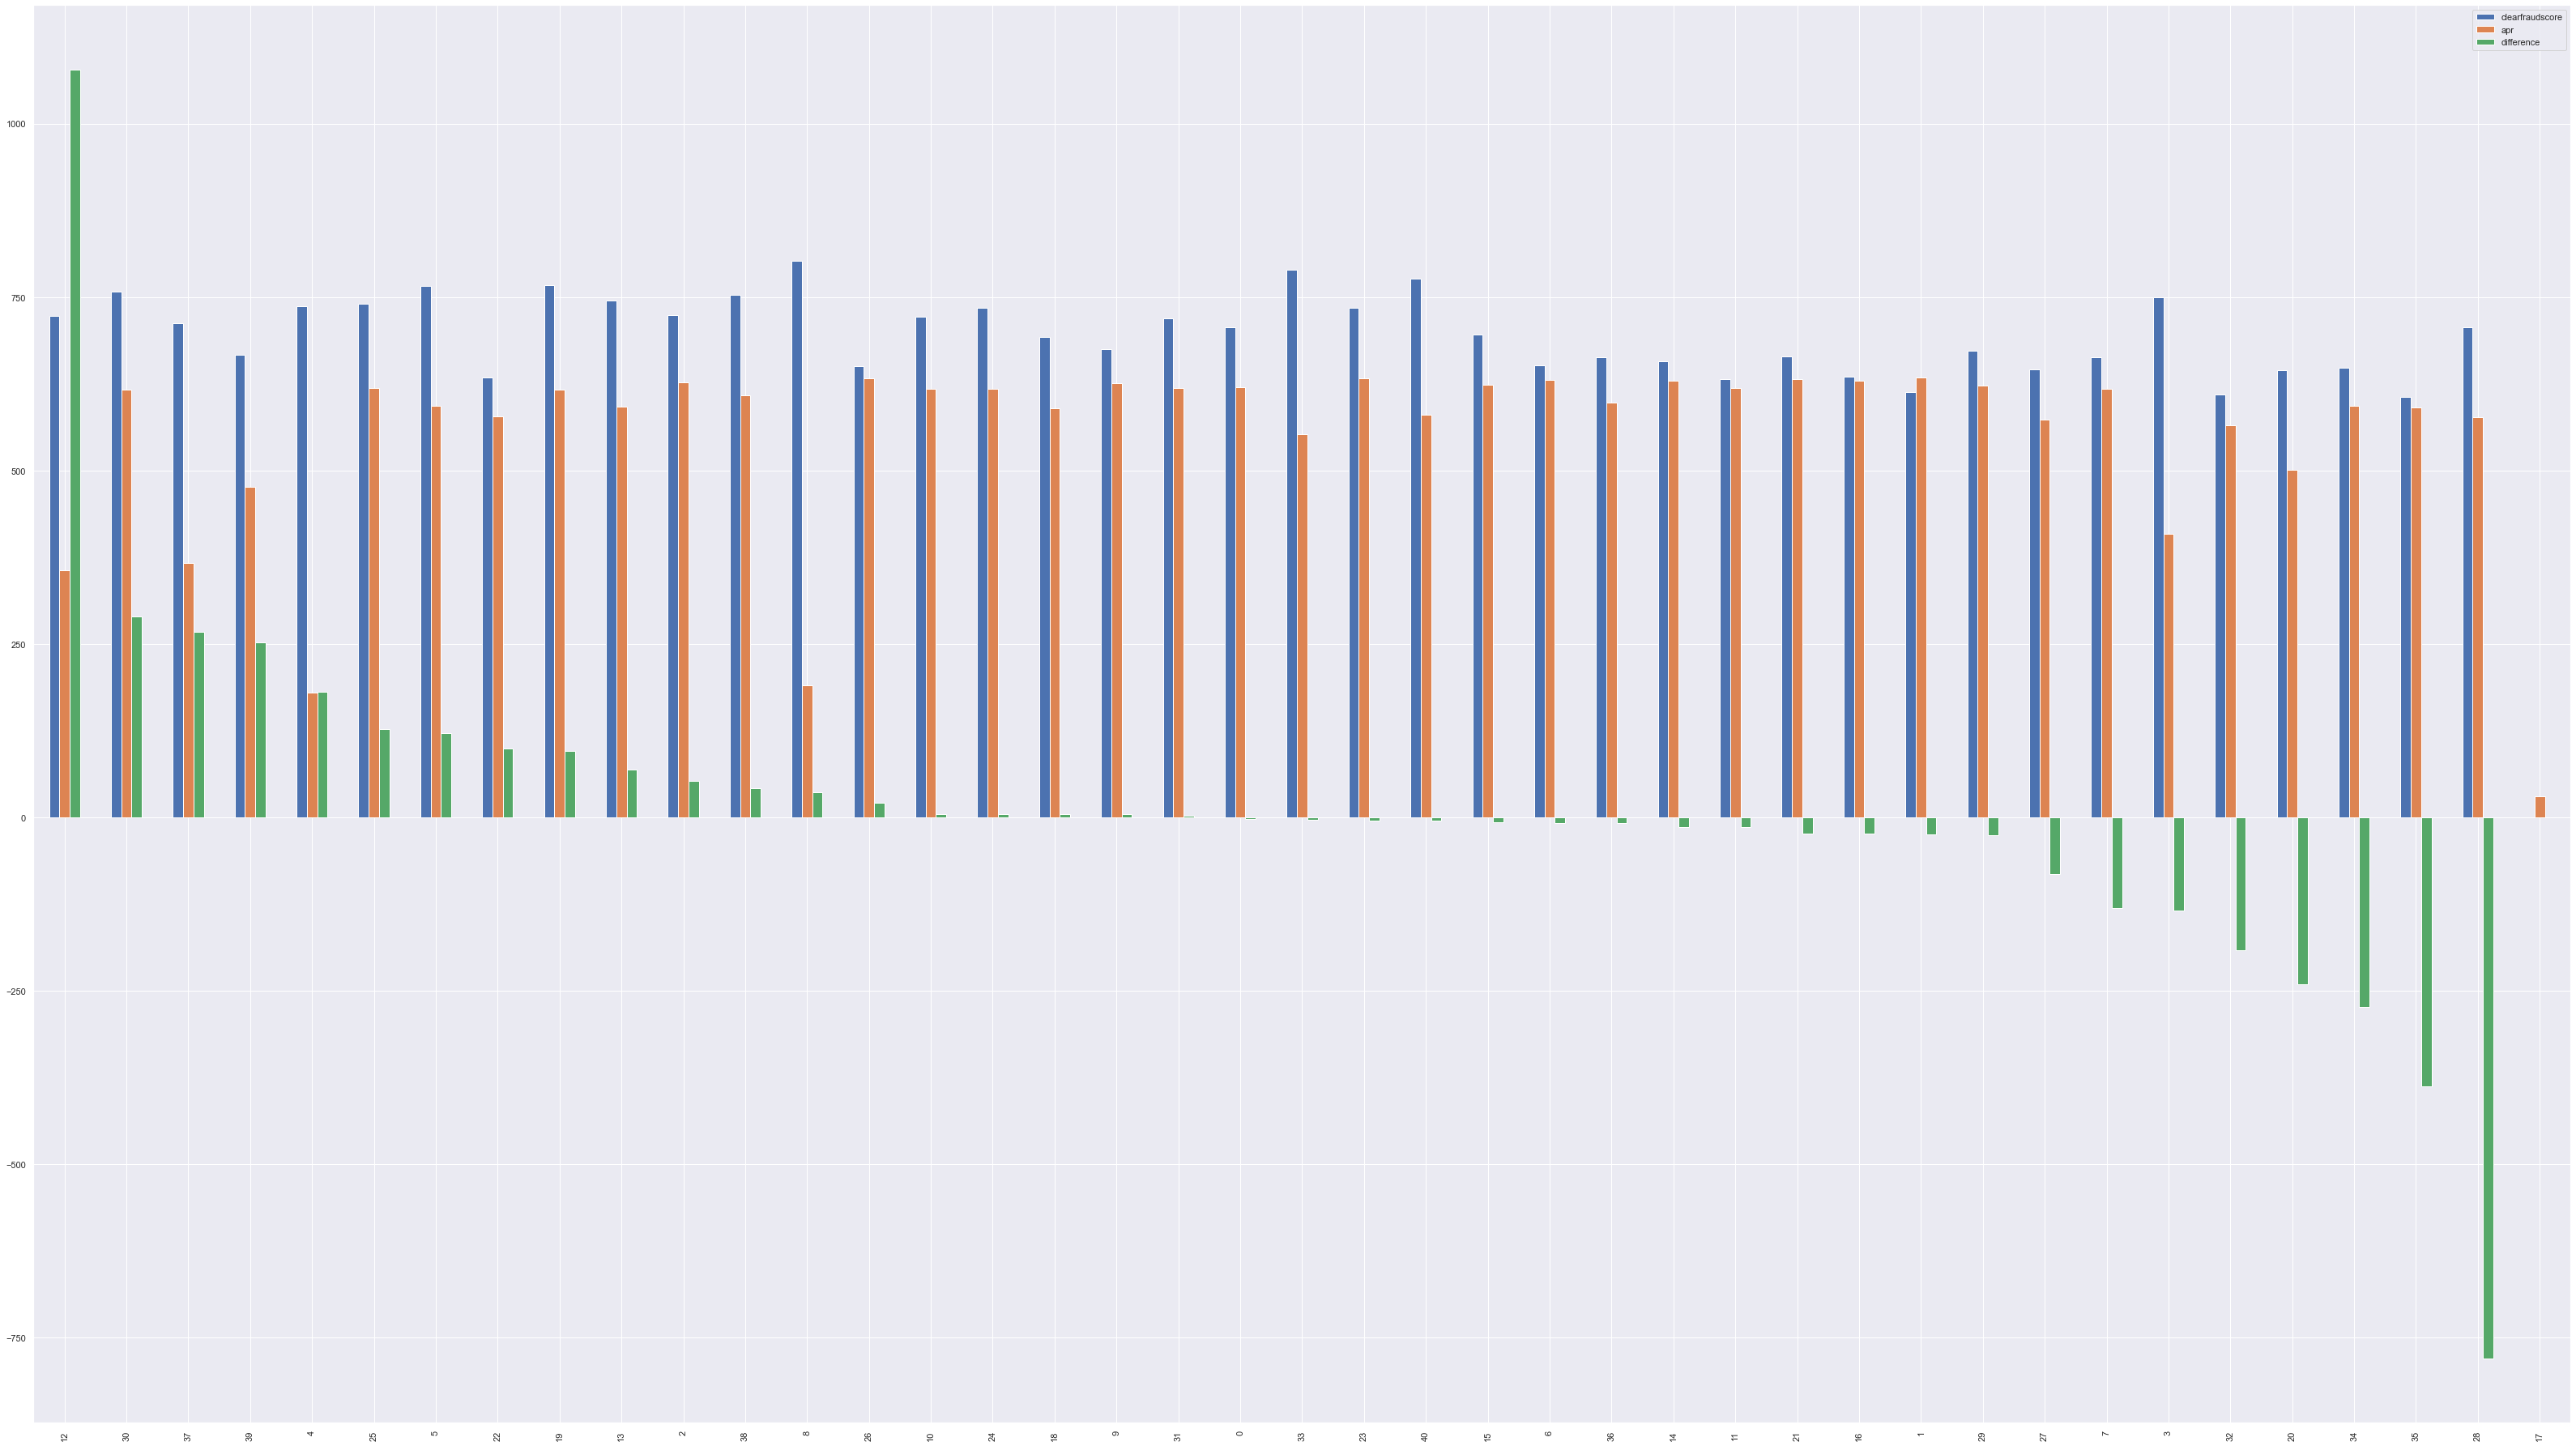

In [57]:
state[['state', 'clearfraudscore', 'apr', 'difference']].sort_values('difference',ascending=False).plot(kind='bar')

In [58]:
df['clearfraudscore'].min(), df['clearfraudscore'].max()

(122.0, 965.0)

In [59]:
risk_cfs = df.groupby('loanRisk').agg({'clearfraudscore':'mean'})
risk_cfs

clearfraudscore
loanRisk                 
High           660.404784
Low            711.486397

In [60]:
sns.set(rc={'figure.figsize':(20, 10)})

<AxesSubplot:xlabel='nPaidOff', ylabel='clearfraudscore'>

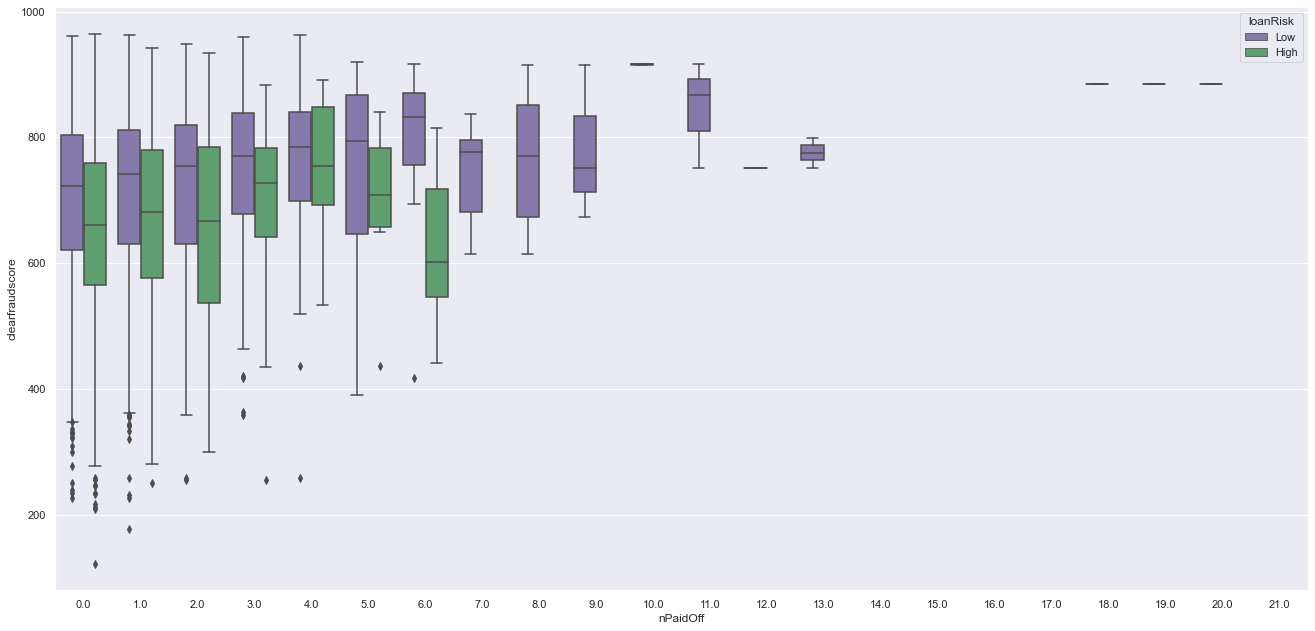

In [61]:
sns.boxplot(data=df, x="nPaidOff", y="clearfraudscore", hue="loanRisk", palette=["m", "g"])

In [62]:
loanRisk_num_encode = {'High' : 1, 'Low' : 0}

df['loanRisk_num'] = df['loanRisk'].map(loanRisk_num_encode)

In [63]:
sns.set(rc={'figure.figsize':(50, 50)})

<AxesSubplot:>

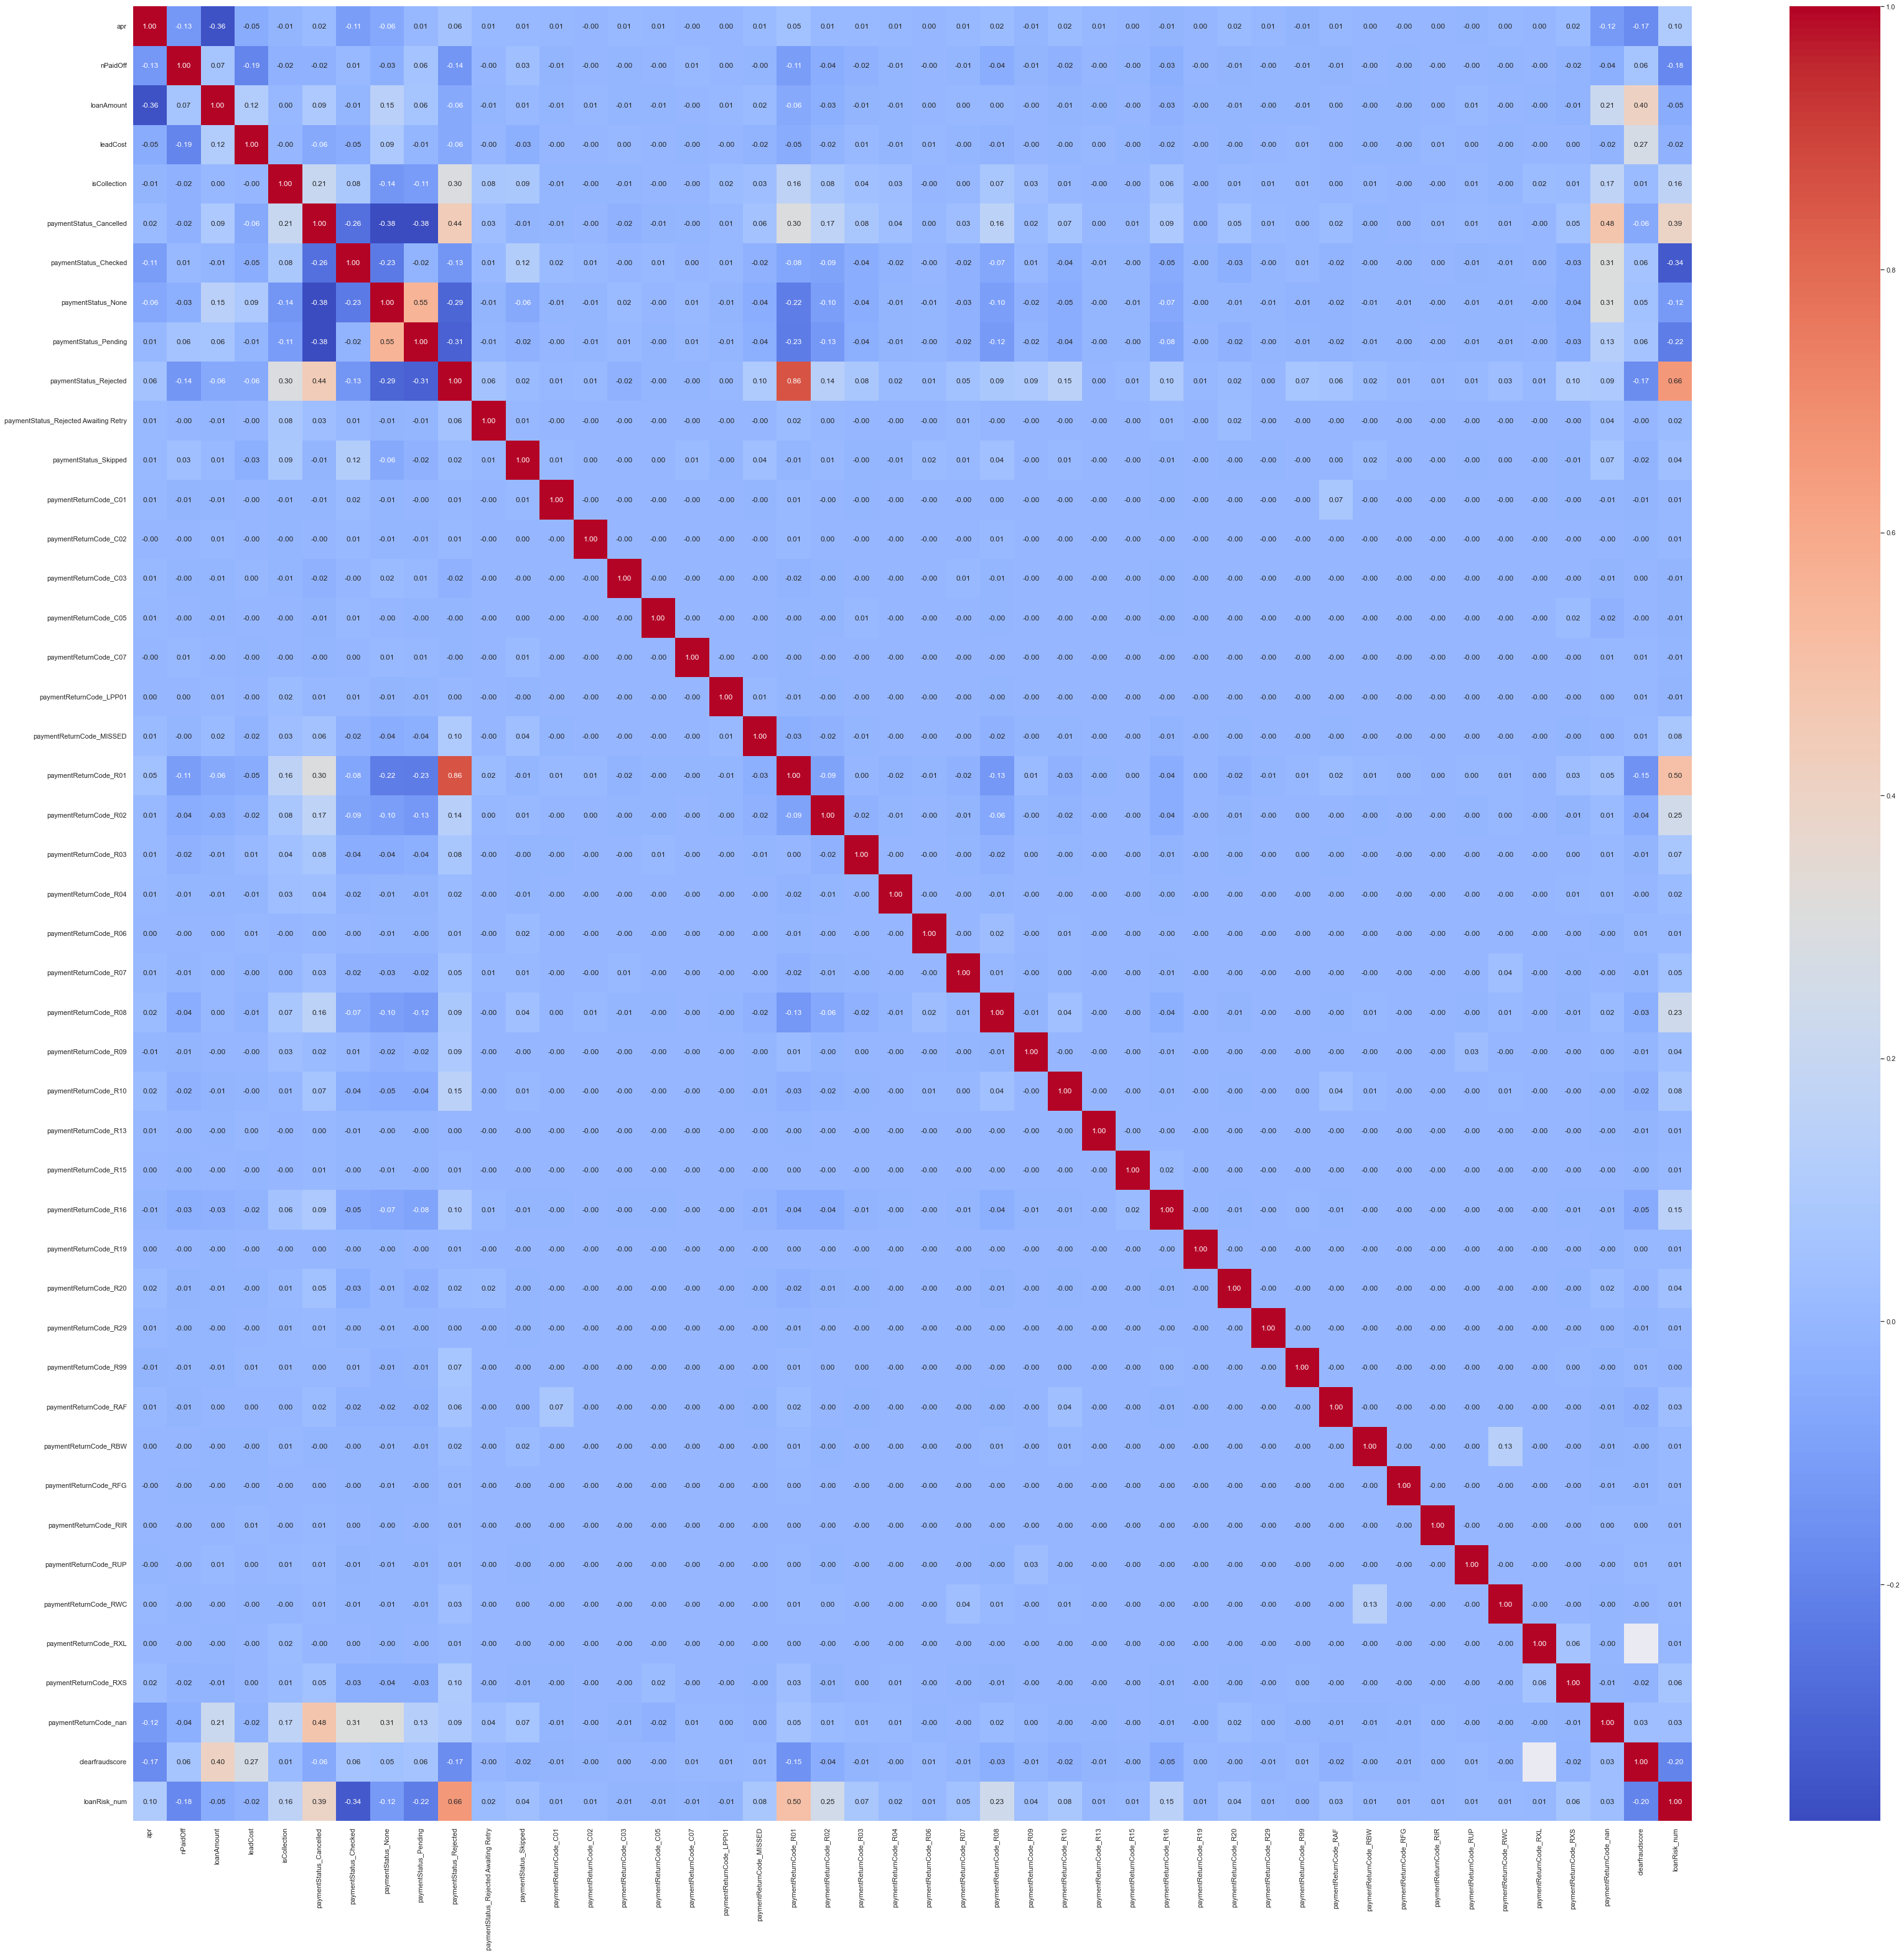

In [64]:
# calculate the correlation matrix
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [65]:
sns.set(rc={'figure.figsize':(10, 10)})

In [66]:
def plot_cat(df, x, y, y_order):
    (df
    .groupby(x)[y]
    .value_counts(normalize=True)
    .mul(100)
    .rename('percent')
    .reset_index()
    .pipe((sns.catplot,'data'), x=x, y='percent', hue=y, hue_order=y_order, kind='bar', height=10, order=['Low','High']))

    plt.show()

In [67]:
y_list = ['payFrequency', 'state', 'leadType', 'fpStatus']
y_order_list = [None, None, None, None]

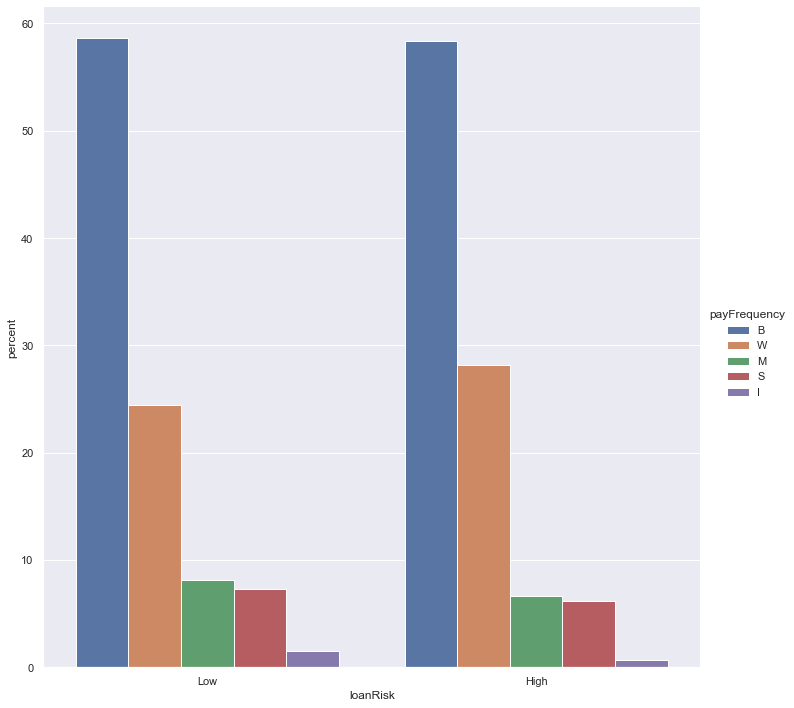

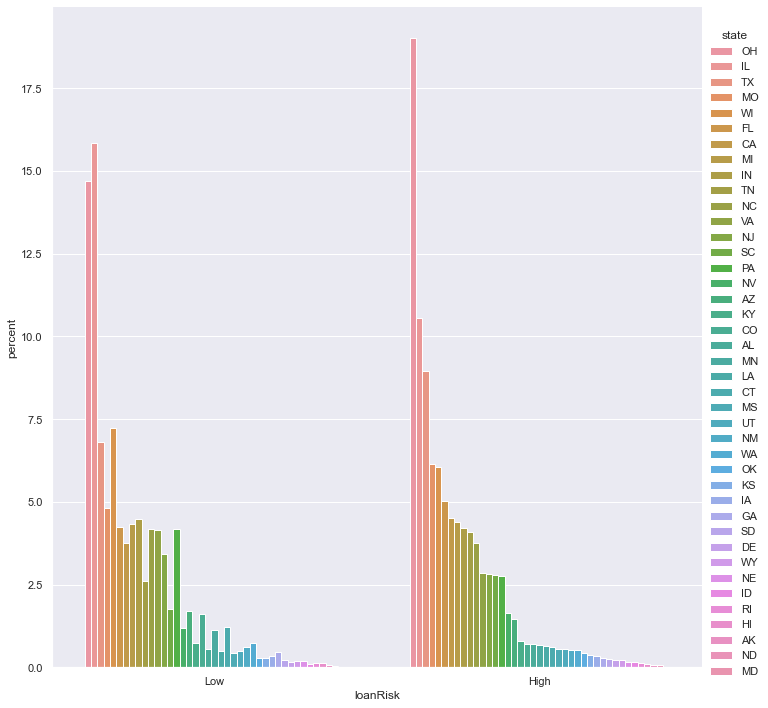

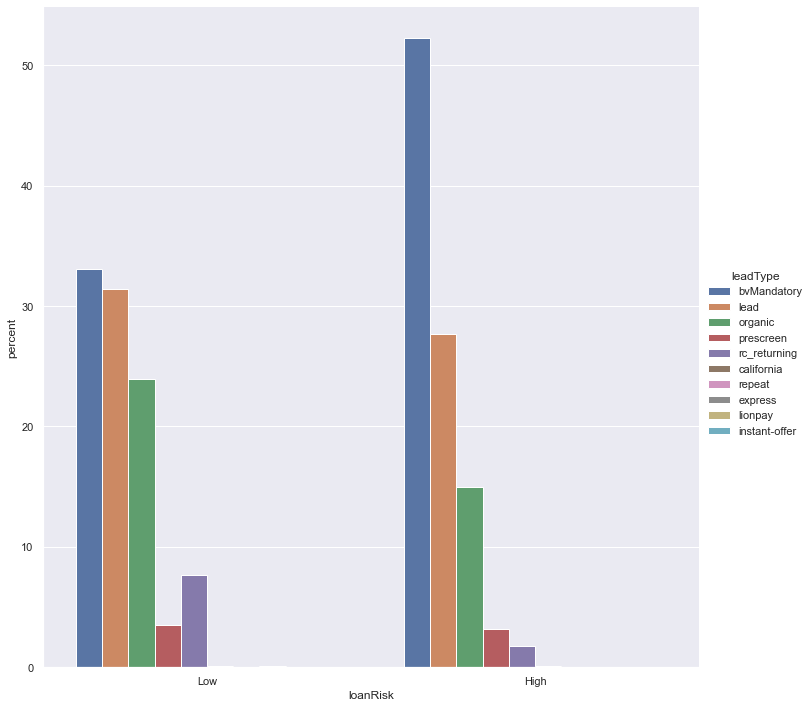

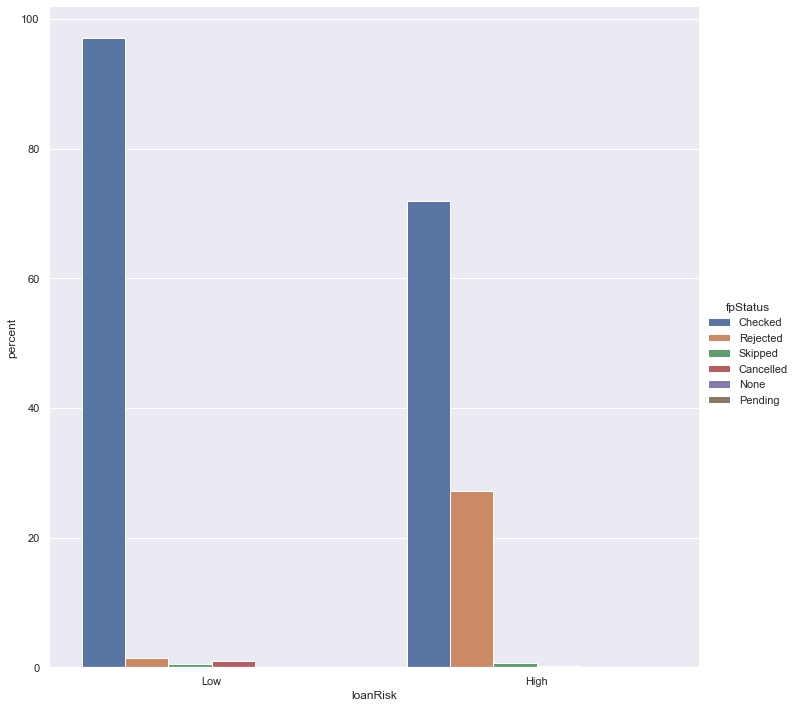

In [68]:
for y, y_order in zip(y_list, y_order_list):
    plot_cat(df=df, x='loanRisk', y=y, y_order=y_order)

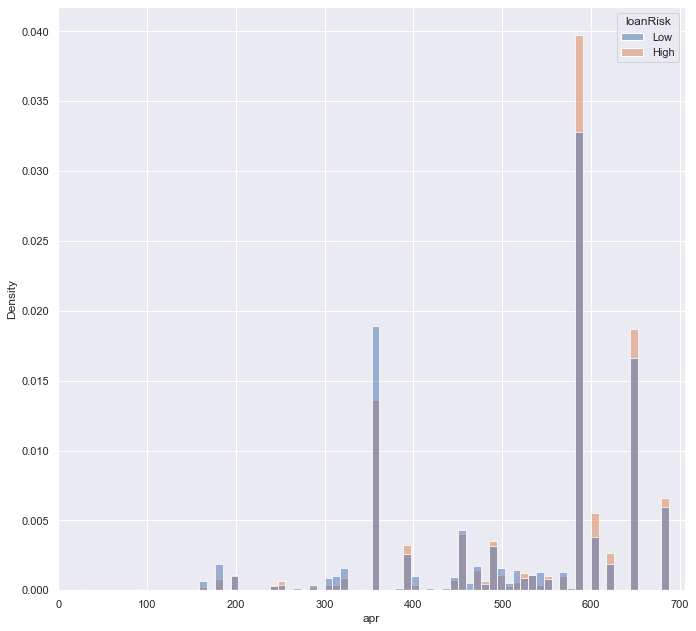

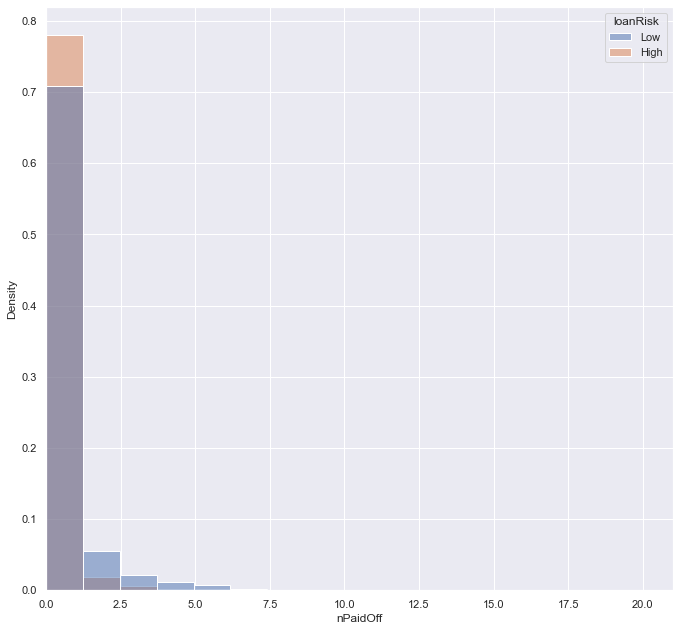

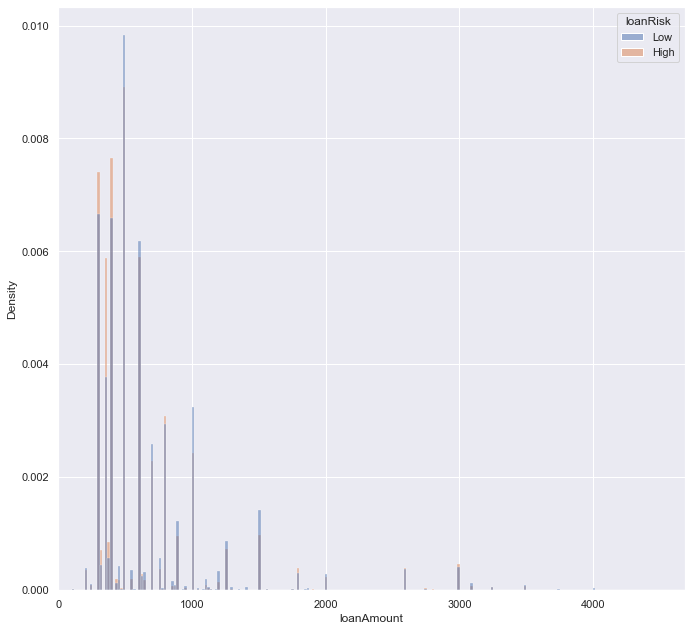

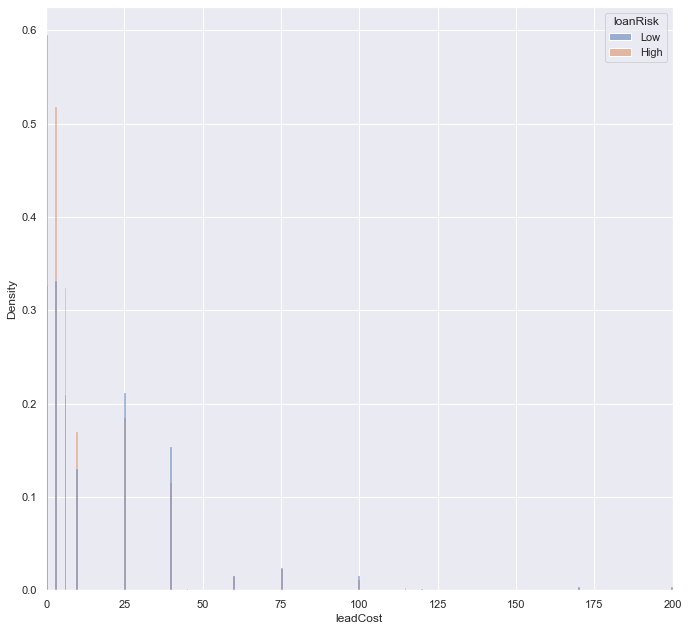

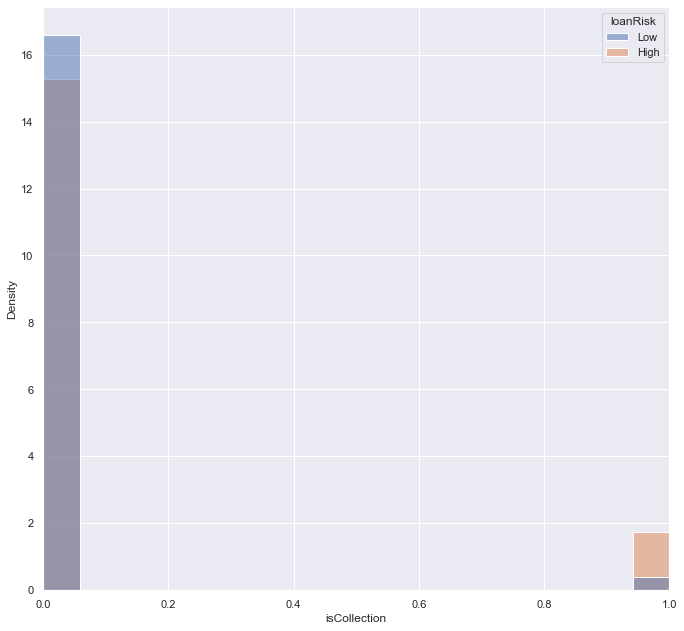

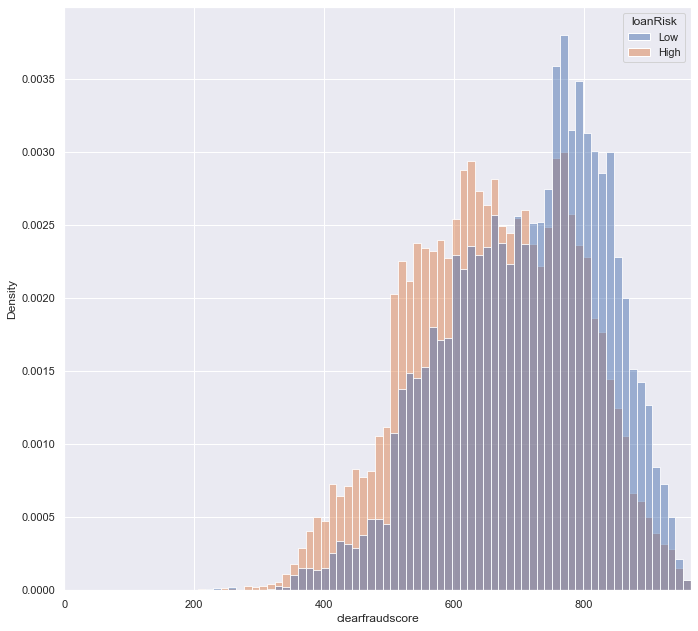

In [69]:
for i in df[['apr', 'nPaidOff', 'loanAmount', 'leadCost', 'isCollection', 'clearfraudscore']].keys():
    sns.histplot(data=df, x=i, hue="loanRisk", multiple="layer", stat='density', common_norm=False).set(xlim=(0,df[i].max()))

    plt.show()

In [70]:
paymentStatus_ReturnCode = df.groupby('loanRisk').agg({
    'paymentStatus_Cancelled': 'mean', 
    'paymentStatus_Checked': 'mean',
    'paymentStatus_None': 'mean', 
    'paymentStatus_Pending': 'mean',
    'paymentStatus_Rejected': 'mean', 
    'paymentStatus_Rejected Awaiting Retry': 'mean',
    'paymentStatus_Skipped': 'mean',
    'paymentReturnCode_C01': 'mean', 
    'paymentReturnCode_C02': 'mean',
    'paymentReturnCode_C03': 'mean', 
    'paymentReturnCode_C05': 'mean',
    'paymentReturnCode_C07': 'mean', 
    'paymentReturnCode_LPP01': 'mean',
    'paymentReturnCode_MISSED': 'mean', 
    'paymentReturnCode_R01': 'mean',
    'paymentReturnCode_R02': 'mean', 
    'paymentReturnCode_R03': 'mean',
    'paymentReturnCode_R04': 'mean', 
    'paymentReturnCode_R06': 'mean',
    'paymentReturnCode_R07': 'mean', 
    'paymentReturnCode_R08': 'mean',
    'paymentReturnCode_R09': 'mean', 
    'paymentReturnCode_R10': 'mean',
    'paymentReturnCode_R13': 'mean', 
    'paymentReturnCode_R15': 'mean',
    'paymentReturnCode_R16': 'mean', 
    'paymentReturnCode_R19': 'mean',
    'paymentReturnCode_R20': 'mean', 
    'paymentReturnCode_R29': 'mean',
    'paymentReturnCode_R99': 'mean', 
    'paymentReturnCode_RAF': 'mean',
    'paymentReturnCode_RBW': 'mean', 
    'paymentReturnCode_RFG': 'mean',
    'paymentReturnCode_RIR': 'mean', 
    'paymentReturnCode_RUP': 'mean',
    'paymentReturnCode_RWC': 'mean', 
    'paymentReturnCode_RXL': 'mean',
    'paymentReturnCode_RXS': 'mean', 
    'paymentReturnCode_nan': 'mean'
})

In [71]:
paymentStatus_ReturnCode = paymentStatus_ReturnCode.transpose()
paymentStatus_ReturnCode['Difference'] = paymentStatus_ReturnCode['High'] - paymentStatus_ReturnCode['Low']
paymentStatus_ReturnCode

loanRisk                                    High        Low  Difference
paymentStatus_Cancelled                 9.682800   3.444677    6.238124
paymentStatus_Checked                   3.353396   7.374701   -4.021304
paymentStatus_None                      3.405380   4.973345   -1.567965
paymentStatus_Pending                   0.128999   0.344019   -0.215020
paymentStatus_Rejected                  1.553646   0.120738    1.432908
paymentStatus_Rejected Awaiting Retry   0.000935   0.000000    0.000935
paymentStatus_Skipped                   0.108330   0.084705    0.023625
paymentReturnCode_C01                   0.002545   0.001835    0.000710
paymentReturnCode_C02                   0.000312   0.000153    0.000159
paymentReturnCode_C03                   0.000571   0.001172   -0.000601
paymentReturnCode_C05                   0.000883   0.004536   -0.003653
paymentReturnCode_C07                   0.000000   0.000102   -0.000102
paymentReturnCode_LPP01                 0.000000   0.000357   -0.000357
paymentReturnCode_MISSED                0.026070   0.001784    0.024286
paymentReturnCode_R01                   1.085584   0.099434    0.986149
paymentReturnCode_R02                   0.138139   0.004842    0.133297
paymentReturnCode_R03                   0.015112   0.001019    0.014093
paymentReturnCode_R04                   0.001818   0.000204    0.001614
paymentReturnCode_R06                   0.000312   0.000000    0.000312
paymentReturnCode_R07                   0.008101   0.000102    0.007999
paymentReturnCode_R08                   0.114354   0.002650    0.111704
paymentReturnCode_R09                   0.007530   0.001529    0.006001
paymentReturnCode_R10                   0.030796   0.000815    0.029980
paymentReturnCode_R13                   0.000104   0.000000    0.000104
paymentReturnCode_R15                   0.000156   0.000000    0.000156
paymentReturnCode_R16                   0.053853   0.002395    0.051458
paymentReturnCode_R19                   0.000052   0.000000    0.000052
paymentReturnCode_R20                   0.004155   0.000102    0.004053
paymentReturnCode_R29                   0.000156   0.000051    0.000105
paymentReturnCode_R99                   0.001610   0.001478    0.000132
paymentReturnCode_RAF                   0.003012   0.000000    0.003012
paymentReturnCode_RBW                   0.000260   0.000000    0.000260
paymentReturnCode_RFG                   0.000156   0.000000    0.000156
paymentReturnCode_RIR                   0.000052   0.000000    0.000052
paymentReturnCode_RUP                   0.000312   0.000000    0.000312
paymentReturnCode_RWC                   0.000364   0.000000    0.000364
paymentReturnCode_RXL                   0.000052   0.000000    0.000052
paymentReturnCode_RXS                   0.011321   0.000408    0.010913
paymentReturnCode_nan                  16.725748  16.217216    0.508532

In [72]:
sns.set(rc={'figure.figsize':(20, 5)})

<AxesSubplot:>

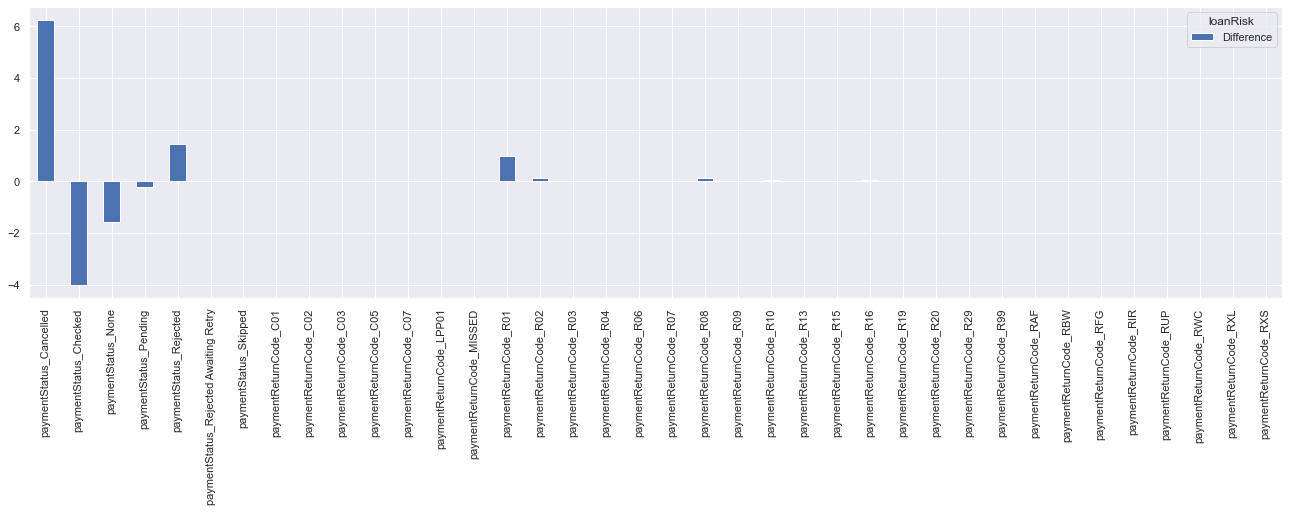

In [73]:
paymentStatus_ReturnCode[['Difference']].drop(['paymentReturnCode_nan'], axis=0).plot(kind='bar')

## Feature Selection

##### 'paymentStatus_Cancelled', 'paymentStatus_Checked', 'paymentStatus_None', 'paymentStatus_Pending', 'paymentStatus_Rejected', 'paymentReturnCode_R01', 'paymentReturnCode_R02', 'paymentReturnCode_R08', 'paymentReturnCode_R16' are selected because the difference of the mean of High and Low is more than 0.1 and correlation coefficient is more than 0.1.

In [74]:
df = df.drop(['paymentStatus_Rejected Awaiting Retry', 'paymentStatus_Skipped', 
              'paymentReturnCode_C01', 'paymentReturnCode_C02', 'paymentReturnCode_C03', 'paymentReturnCode_C05', 
              'paymentReturnCode_C07', 'paymentReturnCode_LPP01', 'paymentReturnCode_MISSED', 'paymentReturnCode_R03', 
              'paymentReturnCode_R04',  'paymentReturnCode_R06', 'paymentReturnCode_R07', 'paymentReturnCode_R09', 
              'paymentReturnCode_R10', 'paymentReturnCode_R13', 'paymentReturnCode_R15', 'paymentReturnCode_R19', 
              'paymentReturnCode_R20', 'paymentReturnCode_R29', 'paymentReturnCode_R99', 'paymentReturnCode_RAF', 
              'paymentReturnCode_RBW', 'paymentReturnCode_RFG', 'paymentReturnCode_RIR', 'paymentReturnCode_RUP', 
              'paymentReturnCode_RWC', 'paymentReturnCode_RXL', 'paymentReturnCode_RXS', 'paymentReturnCode_nan', 
              'loanRisk_num'], axis=1)

In [75]:
df

loanId                          anon_ssn payFrequency    apr  nPaidOff  loanAmount state      leadType  leadCost fpStatus  isCollection  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentReturnCode_R01  paymentReturnCode_R02  paymentReturnCode_R08  paymentReturnCode_R16  clearfraudscore loanRisk
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0       0.0      3000.0    CA     prescreen         0  Checked             0                      3.0                   22.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0            879.0      Low
1      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0       2.0       350.0    MO       organic         0  Checked             0                      0.0                    7.0                 5.0                    1.0                     0.0                    0.0                    0.0                    0.0                    0.0              NaN      Low
2      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0       0.0       400.0    NJ          lead        40  Checked             0                      0.0                    0.0                24.0                    2.0                     0.0                    0.0                    0.0                    0.0                    0.0            658.0      Low
3      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0       2.0      1250.0    MO       organic         0  Checked             0                     12.0                    1.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0            835.0      Low
4      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0       0.0       800.0    CA   bvMandatory        10  Checked             0                      0.0                   13.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0            624.0      Low
...              ...                               ...          ...    ...       ...         ...   ...           ...       ...      ...           ...                      ...                    ...                 ...                    ...                     ...                    ...                    ...                    ...                    ...              ...      ...
38872  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8            B  565.0       3.0       600.0    CA  rc_returning         0  Checked             0                     11.0                    3.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0              NaN      Low
38873  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.0       0.0       375.0    AL          lead        25  Checked             0                      6.0                    1.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0            700.0      Low
38874  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.0       0.0       400.0    WI          lead        40  Checked             0                      0.0                   13.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0            806.0      Low
38875  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B  625.0       0.0       600.0    IN          lead        25  Checked             0                      0.0          

# Data Modelling

In [76]:
df.head(2)

loanId                          anon_ssn payFrequency    apr  nPaidOff  loanAmount state   leadType  leadCost fpStatus  isCollection  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentReturnCode_R01  paymentReturnCode_R02  paymentReturnCode_R08  paymentReturnCode_R16  clearfraudscore loanRisk
0  LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0       0.0      3000.0    CA  prescreen         0  Checked             0                      3.0                   22.0                 0.0                    0.0                     0.0                    0.0                    0.0                    0.0                    0.0            879.0      Low
1  LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0       2.0       350.0    MO    organic         0  Checked             0                      0.0                    7.0                 5.0                    1.0                     0.0                    0.0                    0.0                    0.0                    0.0              NaN      Low

In [77]:
X = df.drop(['loanId', 'anon_ssn', 'loanRisk'], axis=1)
y = df['loanRisk']

One Hot Encoding

In [78]:
cat_columns = X.select_dtypes(include=['object']).columns.tolist()

In [79]:
# Fit OHE
ohe.fit(X[cat_columns])
codes = ohe.transform(X[cat_columns]).toarray()
feature_names = ohe.get_feature_names_out(cat_columns)
categorical_encoded = pd.DataFrame(codes, columns=feature_names).astype(int)

Standardization

In [80]:
scaler = StandardScaler()
cols_to_scale = X._get_numeric_data().keys()
df_numeric_scaled = scaler.fit_transform(X._get_numeric_data())
numerical_standardize = pd.DataFrame(df_numeric_scaled, columns=cols_to_scale)

In [81]:
X_encoded_scaled = pd.concat([categorical_encoded, numerical_standardize],axis=1)
X_encoded_scaled

payFrequency_B  payFrequency_I  payFrequency_M  payFrequency_S  payFrequency_W  state_AK  state_AL  state_AZ  state_CA  state_CO  state_CT  state_DE  state_FL  state_GA  state_HI  state_IA  state_ID  state_IL  state_IN  state_KS  state_KY  state_LA  state_MD  state_MI  state_MN  state_MO  state_MS  state_NC  state_ND  state_NE  state_NJ  state_NM  state_NV  state_OH  state_OK  state_PA  state_RI  state_SC  state_SD  state_TN  state_TX  state_UT  state_VA  state_WA  state_WI  state_WY  leadType_bvMandatory  leadType_california  leadType_express  leadType_instant-offer  leadType_lead  leadType_lionpay  leadType_organic  leadType_prescreen  leadType_rc_returning  leadType_repeat  fpStatus_Cancelled  fpStatus_Checked  fpStatus_None  fpStatus_Pending  fpStatus_Rejected  fpStatus_Skipped       apr  nPaidOff  loanAmount  leadCost  isCollection  paymentStatus_Cancelled  paymentStatus_Checked  paymentStatus_None  paymentStatus_Pending  paymentStatus_Rejected  paymentReturnCode_R01  \
0                   1               0               0               0               0         0         0         0         1         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0                     0                    0                 0                       0              0                 0                 0                   1                      0                0                   0                 1              0                 0                  0                 0 -2.646157 -0.364808    4.980225 -0.588697     -0.258323                -0.444749               2.779880           -0.636923              -0.492322               -0.760383               -0.59774   
1                   1               0               0               0               0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         1         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0                     0                    0                 0                       0              0                 0                 1                   0                      0                0                   0                 1              0                 0                  0                 0 -0.424156  1.596289   -0.606675 -0.588697     -0.258323                -0.822246               0.270521            0.121911               1.580452               -0.760383               -0.59774   
2                   0               0               0               0               1         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         1         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0                     0                    0                 0                       0              1                 0                 0                   0                      0                0                   0                 1              0                 0                  0                 0  0.944468 -0.364808   -0.501262  1.391089     -0.258323                -0.822246              -0.900513            3.005478               3.653226               -0.760383               -0.59774   
3                  

In [82]:
loanRisk_encode = {'High' : 1, 'Low' : 0}

y = y.map(loanRisk_encode)

In [83]:
pd.Series(y).value_counts()

0    19621
1    19256
Name: loanRisk, dtype: int64

In [84]:
# split into 70% training, 15% validating, 15% testing dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_encoded_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42, stratify=y_valid)

In [85]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.value_counts(normalize=True))
print(y_valid.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(27213, 77)
(5832, 77)
(5832, 77)
0    0.504685
1    0.495315
Name: loanRisk, dtype: float64
0    0.50463
1    0.49537
Name: loanRisk, dtype: float64
0    0.504801
1    0.495199
Name: loanRisk, dtype: float64


In [86]:
# Define Model
model = XGBClassifier()

# Define evaluation metric
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

# Evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# Summarize performance
print ('Score: %.5f' % np.mean(scores))

Score: 0.90926


In [87]:
sns.set(rc={'figure.figsize':(10, 30)})

f1-score 0.9108127997496589
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2944
           1       0.94      0.87      0.91      2888

    accuracy                           0.91      5832
   macro avg       0.91      0.91      0.91      5832
weighted avg       0.91      0.91      0.91      5832



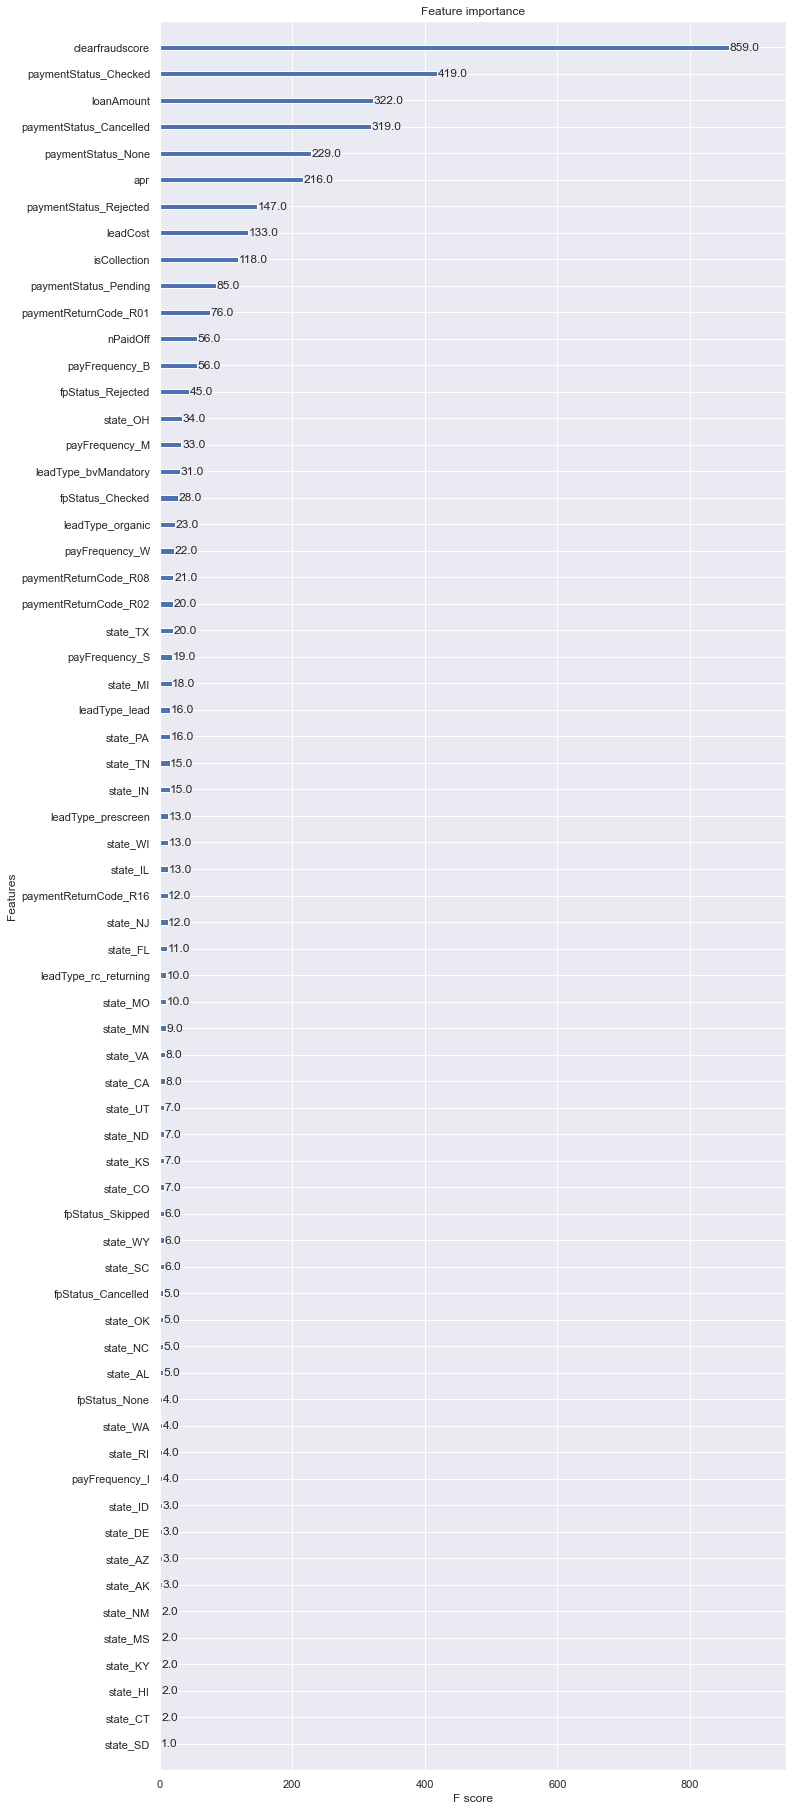

In [88]:
model_1 = XGBClassifier()
model_1.fit(X_train, y_train)
plot_importance(model_1)

# Predict and produce f1_score and classification report
pred = model_1.predict(X_test)
print ("f1-score", f1_score(y_test, pred, average="macro"))
print (classification_report(y_test, pred))

In [89]:
sns.set(rc={'figure.figsize':(5, 5)})

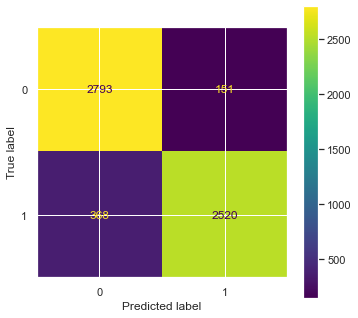

In [90]:
cm = confusion_matrix(y_test, pred, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()

In [ ]:
# Hyper-Parameter Tuning

# Define model
model = XGBClassifier()

# Define grid
weights = [1, 2, 3, 10, 25, 50]
depth= [ 3, 4, 5, 6, 7, 8]
rate=[0.1 , 0.15, 0.2, 0.3, 0.4]

param_grid = dict(scale_pos_weight=weights, max_depth=depth, learning_rate = rate)

# Define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

# Execute the grid search
grid_result = grid.fit(X_train, y_train)

# Report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
sns.set(rc={'figure.figsize':(10, 30)})

In [ ]:
model_1 = XGBClassifier(learning_rate=0.4, max_depth=4, scale_pos_weight=1)
model_1.fit(X_train, y_train)
plot_importance(model_1)

# Predict and produce f1_score and classification report
pred = model_1.predict(X_test)
print ("f1-score", f1_score(y_test, pred, average="macro"))
print (classification_report(y_test, pred))

In [ ]:
sns.set(rc={'figure.figsize':(5, 5)})

In [ ]:
cm = confusion_matrix(y_test, pred, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()

In [ ]:
# Predict and produce f1_score and classification report
pred = model_1.predict(X_valid)
print ("f1-score", f1_score(y_valid, pred, average="macro"))
print (classification_report(y_valid, pred))

In [ ]:
# Predict_proba 
# THRESHOLD = 0.2
# preds = np.where(model_1.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
proba = model_1.predict_proba(X_test)
proba = pd.DataFrame(proba)
proba = proba.drop([0], axis=1)

predicted_data = pd.concat([df[['loanId', 'anon_ssn']].iloc[X_test.index], y_test], axis=1)
predicted_data.reset_index(drop=True, inplace=True)
predicted_data = pd.concat([predicted_data, proba], axis=1)
predicted_data.rename(columns={1:'loanRisk_High_proba'}, inplace=True)
loanRisk_decode = {1 : 'High', 0 : 'Low'}
predicted_data['loanRisk'] = predicted_data['loanRisk'].map(loanRisk_decode)
predicted_data

In [ ]:
sns.histplot(data=predicted_data, x="loanRisk_High_proba")